# Import tools and data

### Import packages

In [1]:
import pandas as pd
import glob
import numpy as np
import json
import sqlite3
import re
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

### Import data

In [2]:
#master data for reference
conn = sqlite3.connect("../data/db/gfm.db")
master = pd.read_sql_query("SELECT url,fund_description FROM master", conn)

In [3]:
master.shape

(89645, 2)

In [4]:
#disease hierarchy
ccsr = pd.read_csv('../data/ccsr/disease_hierarchy.csv')

In [5]:
#entity recognition outout
path = '../data/disease_categorization/output_new' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

er = pd.concat(li, axis=0, ignore_index=True)

In [6]:
#entity recognition output deidentification map
deid = pd.read_csv('../data/disease_categorization/url_deid_map.csv')

In [7]:
#entity recognition output, additional campaigns
more = pd.read_csv('../data/disease_categorization/more_for_spark_output.csv')

In [8]:
#manually labeled reference set
ref = pd.read_csv('../data/disease_categorization/evaluation/final_reference.csv')

# Clean data

### Clean categorization output

#### Re-identify campaigns

In [9]:
deid['url_deid'] = deid['url_deid'].astype(int)
er['url'] = er['url'].astype(int)
er = er.merge(deid, left_on='url', right_on='url_deid', how='left')
er = er[['url_y','chunks','begin','end','sent','code','results','resolutions','res_distances']]
er = er.rename(columns = {'url_y':'url', 'code':'entity_code'})

#### Add additional campaigns

In [10]:
more.rename(columns={'code':'entity_code'},inplace=True)

In [11]:
er = pd.concat([er, more], axis=0)

### Were any campaigns from master data not subjected to disease categorization?

In [12]:
more_input = pd.read_csv('../data/disease_categorization/more_for_spark.csv')

In [13]:
urls = deid['url'].tolist() + more_input['url'].tolist()

In [14]:
#takes a little while
for url in master['url']:
    if url in urls:
        continue
    else:
        print(url)
print('all done')

all done


All campaigns from master data were subjected to disease categorization

### Were any campaigns from reference data not subjected to disease categorization

In [15]:
for url in ref['url']:
    if url in urls:
        continue
    else:
        print(url)
print('all done')

all done


### Subset ER data

In [16]:
er = er[er['url'].isin(master['url'].tolist())]

### Inspect data

In [17]:
er.head()

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances
0,https://www.gofundme.com/f/sandi-rustad,Metaplastic breast cancer,33.0,57.0,0,C5091,C5091:::C5092:::C509:::C5061:::C4352:::C5041::...,metaplastic carcinoma of breast:::metaplastic ...,5.5764:::6.6196:::7.2053:::7.4696:::7.4981:::7...
1,https://www.gofundme.com/f/sandi-rustad,cancer,103.0,108.0,1,C801,C801:::C569:::Z809:::C809:::C800:::D099:::Z859...,cancer:::generalized cancer:::fh: cancer - *::...,0.0000:::7.5123:::7.7614:::8.1281:::8.1928:::8...
2,https://www.gofundme.com/f/lktjl0,brain cancer,44.0,55.0,0,D496,D496:::C710:::C793:::D432:::C718:::C719:::C717...,brain tumor:::carcinoma of brain:::secondary c...,7.1362:::7.1587:::7.8662:::7.9386:::8.8884:::9...
3,https://www.gofundme.com/f/lktjl0,Cancer,349.0,354.0,5,C801,C801:::Z809:::Z859:::C800:::C569:::Z129:::C809...,cancer:::fh: cancer - *:::h/o: cancer:::ca - m...,5.4193:::7.1018:::8.0088:::8.3601:::8.4044:::9...
4,https://www.gofundme.com/f/lktjl0,cancer,479.0,484.0,7,C801,C801:::C569:::Z809:::C809:::C800:::D099:::Z859...,cancer:::generalized cancer:::fh: cancer - *::...,0.0000:::7.5123:::7.7614:::8.1281:::8.1928:::8...


In [18]:
er.shape

(276020, 9)

In [19]:
unique_codes_n = er['entity_code'].nunique()
print(unique_codes_n)

6594


In [20]:
unique_urls_n = er['url'].nunique()
print(unique_urls_n)

75454


### Recode autism

"resolutions" column is correct, but the ICD code does not seem correct

In [21]:
er[er['chunks'].str.contains('autism')].head()

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances
1308,https://www.gofundme.com/f/6u7abs,autism,704.0,709.0,7,G4090,G4090:::Z134:::Q9389:::F849:::R4189:::E7119:::...,autism:::suspected autism:::autism disorder:::...,0.0000:::6.6234:::6.8922:::8.0960:::8.4410:::8...
4524,https://www.gofundme.com/f/JPHaigler,autism,583.0,588.0,7,G4090,G4090:::Z134:::Q9389:::F849:::R4189:::E7119:::...,autism:::suspected autism:::autism disorder:::...,0.0000:::6.6234:::6.8922:::8.0960:::8.4410:::8...
6833,https://www.gofundme.com/f/jane-brogan,autism,1056.0,1061.0,11,G4090,G4090:::Z134:::Q9389:::F849:::R4189:::E7119:::...,autism:::suspected autism:::autism disorder:::...,0.0000:::6.6234:::6.8922:::8.0960:::8.4410:::8...
7020,https://www.gofundme.com/f/BrinleysBuddy,autism,775.0,780.0,11,G4090,G4090:::Z134:::Q9389:::F849:::R4189:::E7119:::...,autism:::suspected autism:::autism disorder:::...,0.0000:::6.6234:::6.8922:::8.0960:::8.4410:::8...
7869,https://www.gofundme.com/f/z44yr2ms,autism,3094.0,3099.0,32,G4090,G4090:::Z134:::Q9389:::F849:::R4189:::E7119:::...,autism:::suspected autism:::autism disorder:::...,0.0000:::6.6234:::6.8922:::8.0960:::8.4410:::8...


In [22]:
er.loc[er['chunks'].str.lower().str.contains('autism'),'entity_code'] = 'F840'
er.loc[er['chunks'].str.lower().str.contains('autistic'),'entity_code'] = 'F840'

### Match ICD codes from entity resolution with categories from CCSR

In [23]:
raw_codes = er['entity_code'].unique().tolist()

In [24]:
ccsr_codes = ccsr['icd_10_cm_code'].tolist()

In [25]:
def StemCode(code, ccsr):
    '''
    variation in previous versions due to this error:
    https://stackoverflow.com/questions/51933763/pandas-series-value-counts-returns-inconsistent-order-for-equal-count-strings
    '''
    res = 0
    while res == 0:
        sub = ccsr[ccsr['icd_10_cm_code'].str.startswith(code)]
        res = sub.shape[0]
        if res > 0:
            #cats = sub['ccsr_category'].value_counts().index[0]
            #return code, cats
            val_counts_df = sub['ccsr_category'].value_counts().to_frame().reset_index()
            max_freq = val_counts_df['ccsr_category'][0]
            #subset further to get all categories that have that frequency (aka a tie)
            sub_max_freq = val_counts_df[val_counts_df['ccsr_category'] == max_freq]
            if sub_max_freq.shape[0] >1:
                #randomly sample from all categories that are tied
                #cats = sub_max_freq.sample()['index'].tolist()[0]
                #select first category alphabetically
                cats = sub_max_freq.sort_values('index')['index'].tolist()[0]
            else:
                cats = sub_max_freq['index'][0]
            return code, cats
        else:
            code = code[:-1]
            if len(code) == 0:
                print('error - no code stem')
                return np.nan, np.nan

In [26]:
def GetCodeMatch(raw_codes, ccsr_codes, ccsr):

    #define results container for best match
    best_match = []

    #loop through raw codes
    for raw in raw_codes:
        #if raw code exists in CCSR as-is
        if raw in ccsr_codes:
            #no need to define best match as exact match already exists
            continue
        else:
            #see if there are any codes that start with code
            #if not, remove final character, try again
            #once codes are found, select the ccsr_cateogry that is most common
            matched_code, ccsr_cat = StemCode(raw, ccsr)
            best_match.append({'raw_code':raw, 'matched_code_stem':matched_code,'matched_ccsr_category':ccsr_cat})

    return best_match

In [27]:
#takes a little while
best_match_map = GetCodeMatch(raw_codes, ccsr_codes, ccsr)

error - no code stem
error - no code stem


In [28]:
best_match_map = pd.DataFrame(best_match_map).merge(ccsr[['ccsr_category','disease_category']].drop_duplicates('ccsr_category'), 
                                                    left_on='matched_ccsr_category', 
                                                    right_on='ccsr_category', 
                                                    how='left')

In [29]:
#inspect code n=2 stem errors
best_match_map[best_match_map['matched_code_stem'].isna()]

,raw_code,matched_code_stem,matched_ccsr_category,ccsr_category,disease_category
1678,d430,NaN,NaN,NaN,NaN
2302,q878,NaN,NaN,NaN,NaN


In [30]:
er[(er['entity_code'] == 'q878')|(er['entity_code'] == 'd430')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances
77811,https://www.gofundme.com/f/2fubvk4,tumors on Linda's brain,2099.0,2121.0,34,d430,d430:::D331:::D432:::D497:::C710:::C719:::D239...,tumor of hypothalamus:::cerebellopontine angle...,9.7123:::9.8830:::9.9242:::9.9815:::10.0045:::...
108687,https://www.gofundme.com/f/qggaeey8,tumors of the hypothalamus,152.0,177.0,1,d430,d430:::C710:::D443:::D430:::D496:::C751:::D330...,tumor of hypothalamus:::malignant tumor of hyp...,3.0166:::4.8998:::5.0649:::5.2426:::5.5834:::6...
157591,https://www.gofundme.com/f/baby-delaynie,Zellweger spectrum disorders,709.0,736.0,5,q878,q878:::Q878:::E7151:::E7154:::E803:::Q777:::Q1...,zellweger syndrome (disorder):::zellweger's sy...,7.2023:::7.3898:::7.4975:::8.0355:::8.4334:::9...


In [31]:
#both appear to be a capitalization issues
er.loc[er['entity_code'] == 'q878','entity_code'] = 'Q878'
er.loc[er['entity_code'] == 'd430','entity_code'] = 'D430'

In [32]:
#rerun after correcting capitalization issue from Spark output
raw_codes = er['entity_code'].unique().tolist()
best_match_map = GetCodeMatch(raw_codes, ccsr_codes, ccsr)

No errors after running above cell

In [33]:
# best_match_map = pd.DataFrame(best_match_map).merge(ccsr[['ccsr_category','int_category','disease_category']].drop_duplicates('ccsr_category'), 
#                                                     left_on='matched_ccsr_category', 
#                                                     right_on='ccsr_category', 
#                                                     how='left')

best_match_map = pd.DataFrame(best_match_map).merge(ccsr[['ccsr_category','disease_category']].drop_duplicates('ccsr_category'), 
                                                    left_on='matched_ccsr_category', 
                                                    right_on='ccsr_category', 
                                                    how='left')

In [34]:
best_match_map.to_csv('../data/disease_categorization/best_match_map.csv', index=False)

In [35]:
unique_best_match_n = best_match_map.shape[0]
print(unique_best_match_n)
print(unique_best_match_n/unique_codes_n)

2884
0.43736730360934184


In [36]:
pd.Series([len(x) for x in best_match_map['matched_code_stem']]).value_counts()

5    1321
4    1176
3     292
2      75
1      20
dtype: int64

In [37]:
20/unique_best_match_n

0.006934812760055479

### Disease category assignment of initially unmatched codes

In [38]:
best_match_map['disease_category'].value_counts()

Injuries and external causes          960
Exclude                               944
Musculoskeletal diseases              316
Neoplasms                             167
Nervous system diseases               107
Cardiovascular diseases                73
Endocrine diseases                     66
Gastrointestinal diseases              59
Mental and substance use disorders     57
Genitourinary diseases                 50
Infections                             45
Respiratory diseases                   40
Name: disease_category, dtype: int64

In [39]:
best_match_map['len_raw'] = [len(x) for x in best_match_map['raw_code']]
best_match_map['len_matched'] = [len(x) for x in best_match_map['matched_code_stem']]
best_match_map['len_diff'] = best_match_map['len_raw'] - best_match_map['len_matched']

In [40]:
best_match_map['len_diff'].value_counts()

0    2544
1     250
2      72
3      18
Name: len_diff, dtype: int64

In [41]:
2544/2884

0.8821081830790569

### Replace best-matched entity codes

In [42]:
#subset dataframe for those that need best matched data
er_for_best_match = er[er['entity_code'].isin(best_match_map['raw_code'].tolist())]
er_rest = er[~er['entity_code'].isin(er_for_best_match['entity_code'].tolist())]

### Merge ER data with appropriate disease categories

In [43]:
#best match
er_for_best_match = er_for_best_match.merge(best_match_map, left_on='entity_code', right_on='raw_code', how='left')
del er_for_best_match['matched_code_stem']
del er_for_best_match['matched_ccsr_category']
er_for_best_match.loc[:,'icd_10_cm_code_desc'] = ['best_match' for x in range(len(er_for_best_match))]
er_for_best_match.rename(columns={'raw_code':'icd_10_cm_code'}, inplace=True)

#exact match
er_rest = er_rest.merge(ccsr, left_on='entity_code', right_on='icd_10_cm_code', how='left')

In [44]:
#concatenate dataframes
er_final = pd.concat([er_for_best_match, er_rest])

In [45]:
print(er_final.shape)
print(er.shape)
print('\n')
print(er_final['url'].nunique())
print(er['url'].nunique())

(276020, 16)
(276020, 9)


75454
75454


### Exclude named entities that map to certain disease categories

In [46]:
starting_n = er_final['entity_code'].nunique()
er_final = er_final[~er_final['disease_category'].isin(['Exclude'])]
exclude_cat_n = starting_n - er_final['entity_code'].nunique()
print(exclude_cat_n)

2046


In [47]:
print(exclude_cat_n/starting_n)

0.3105646630236794


In [48]:
er_final['url'].nunique()

70755

### Find additional clinical entities to infer disease category

In [49]:
def SearchProcedures(df):

    r = {}

    terms = ['dialysis',
             'renal transplant',
             'kidney transplant',
             'lung transplant',
             'heart transplant',
             'heart surgery',
             'chemo',
             'chemotherapy',
             'radiation',
             'radiotherapy',
             'bone marrow transplant',
             'liver transplant',
             "accident","injury","injuries","injured","crash","collision","injured","burn","burned","burns"]

    for term in terms:

        #define regex
        regex = r"\b{}\b".format(term)

        #apply regex search
        search = df['fund_description'].apply(lambda x: re.search(regex, x))

        #get start and end
        start = [x.start() if x != None else np.nan for x in search]
        end = [x.end() if x != None else np.nan for x in search]

        #add to results
        r[term] = {'start':start,'end':end}
    
    return r


In [50]:
search_results = SearchProcedures(master) #takes about 30 seconds

In [51]:
def SearchToDF(search_results):

    r = []

    for k,v in search_results.items():

        new_df = pd.DataFrame({'url':master['url'].tolist(),'begin':v['start'],'end':v['end']})

        new_df = new_df.dropna()

        new_df['chunks'] = [k for x in range(len(new_df))]
        new_df['sent'] = [np.nan for x in range(len(new_df))]
        new_df['entity_code'] = ['regex_search' for x in range(len(new_df))]
        new_df['results'] = [np.nan for x in range(len(new_df))]
        new_df['resolutions'] = [np.nan for x in range(len(new_df))]
        new_df['res_distances'] = [np.nan for x in range(len(new_df))]
        new_df['icd_10_cm_code'] = ['regex_search' for x in range(len(new_df))]
        new_df['icd_10_cm_code_desc'] = [k for x in range(len(new_df))]


        if k in ['dialysis','renal transplant','kidney transplant']:
            new_df['ccsr_category'] = ['GU_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['CKD and renal failure' for x in range(len(new_df))]
            new_df['disease_category'] = ['Genitourinary diseases' for x in range(len(new_df))]

        elif k in ['lung transplant']:
            new_df['ccsr_category'] = ['RESP_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other respiratory disorders' for x in range(len(new_df))]
            new_df['disease_category'] = ['Respiratory diseases' for x in range(len(new_df))]

        elif k in ['heart transplant','heart surgery']:
            new_df['ccsr_category'] = ['CV_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other cardiovascular disorders' for x in range(len(new_df))]
            new_df['disease_category'] = ['Cardiovascular diseases' for x in range(len(new_df))]

        elif k in ['chemo','chemotherapy','radiation','radiotherapy','bone marrow transplant']:
            new_df['ccsr_category'] = ['NEO_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other neoplasms' for x in range(len(new_df))]
            new_df['disease_category'] = ['Neoplasms' for x in range(len(new_df))]

        elif k in ['liver transplant']:
            new_df['ccsr_category'] = ['GI_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Liver diseases' for x in range(len(new_df))]
            new_df['disease_category'] = ['Gastrointestinal diseases' for x in range(len(new_df))]
        
        elif k in ["accident","injury","injuries","injured","crash","collision","injured","burn","burned","burns"]:
            new_df['ccsr_category'] = ['INJ_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other injuries' for x in range(len(new_df))]
            new_df['disease_category'] = ['Injuries and external causes' for x in range(len(new_df))]

        r.append(new_df)

    return pd.concat(r)

In [52]:
search_results_df = SearchToDF(search_results)

#### Among newly-added campaigns, which search terms were responsible?

In [53]:
search_sub = search_results_df[~search_results_df['url'].isin(er_final['url'].unique())]

In [54]:
search_sub['url'].nunique()

3261

In [55]:
search_sub[['url','disease_category']].drop_duplicates()['disease_category'].value_counts()

Injuries and external causes    1586
Cardiovascular diseases          598
Neoplasms                        486
Genitourinary diseases           428
Gastrointestinal diseases        135
Respiratory diseases              74
Name: disease_category, dtype: int64

In [56]:
search_sub[['url','chunks']].drop_duplicates()['chunks'].value_counts()

accident                  1459
heart surgery              444
dialysis                   296
chemo                      246
kidney transplant          228
heart transplant           166
chemotherapy               158
liver transplant           135
bone marrow transplant     118
radiation                   97
lung transplant             74
crash                       61
collision                   38
burn                        27
burned                      22
injury                      14
injuries                    14
injured                     12
radiotherapy                 1
Name: chunks, dtype: int64

In [57]:
search_sub[search_sub['chunks'].str.contains('injury|injuries|injured')]['url'].nunique()

38

In [58]:
search_sub[search_sub['chunks'].str.contains('burn|burns|burned')]['url'].nunique()

45

In [59]:
search_sub[search_sub['chunks'].str.contains('chemo|chemotherapy')]['url'].nunique()

381

In [60]:
search_sub[search_sub['chunks'].str.contains('radiation|radiotherapy')]['url'].nunique()

98

In [61]:
mm_app_4_left = pd.DataFrame([
    {'word':'accident','count':1459, 'cat':'Injuries and external causes'},
    {'word':'injury/injuries/injured','count':38, 'cat':'Injuries and external causes'},
    {'word':'crash','count':61, 'cat':'Injuries and external causes'},
    {'word':'collision','count':38, 'cat':'Injuries and external causes'},
    {'word':'burn/burns/burned','count':45, 'cat':'Injuries and external causes'},
    {'word':'heart transplant','count':166, 'cat':'Cardiovascular diseases'},
    {'word':'heart surgery','count':444, 'cat':'Cardiovascular diseases'},
    {'word':'chemo/chemotherapy','count':381, 'cat':'Neoplasms'},
    {'word':'radiation/radiotherapy','count':97, 'cat':'Neoplasms'},
    {'word':'bone marrow transplant','count':118, 'cat':'Neoplasms'},
    {'word':'dialysis','count':296, 'cat':'Genitourinary diseases'},
    {'word':'kidney/renal transplant','count':228, 'cat':'Genitourinary diseases'},
    {'word':'liver transplant','count':135, 'cat':'Gastrointestinal diseases'},
    {'word':'lung transplant','count':74, 'cat':'Respiratory diseases'},
])

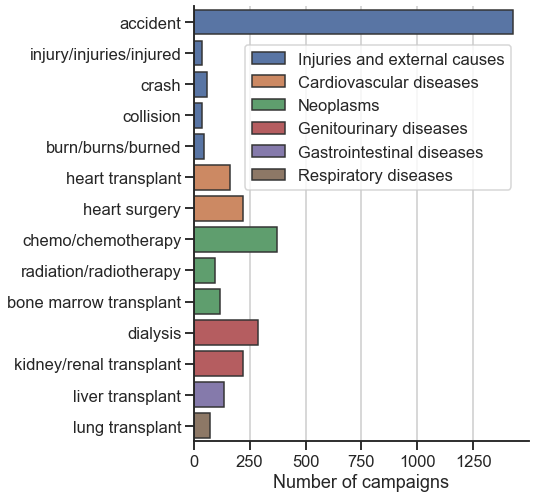

In [62]:


d = pd.DataFrame([
    {'word':'accident','count':1427, 'cat':'Injuries and external causes'},
    {'word':'injury/injuries/injured','count':38, 'cat':'Injuries and external causes'},
    {'word':'crash','count':57, 'cat':'Injuries and external causes'},
    {'word':'collision','count':38, 'cat':'Injuries and external causes'},
    {'word':'burn/burns/burned','count':44, 'cat':'Injuries and external causes'},
    {'word':'heart transplant','count':163, 'cat':'Cardiovascular diseases'},
    {'word':'heart surgery','count':222, 'cat':'Cardiovascular diseases'},
    {'word':'chemo/chemotherapy','count':373, 'cat':'Neoplasms'},
    {'word':'radiation/radiotherapy','count':97, 'cat':'Neoplasms'},
    {'word':'bone marrow transplant','count':118, 'cat':'Neoplasms'},
    {'word':'dialysis','count':286, 'cat':'Genitourinary diseases'},
    {'word':'kidney/renal transplant','count':222, 'cat':'Genitourinary diseases'},
    {'word':'liver transplant','count':133, 'cat':'Gastrointestinal diseases'},
    {'word':'lung transplant','count':73, 'cat':'Respiratory diseases'},
])

sns.set(style="ticks")
sns.set_context('talk', font_scale=1)
plt.figure(figsize=(6, 8))
ax = sns.barplot(y='word', x='count', data=d, hue='cat', edgecolor=".2",
                dodge=False)
ax.set_xlabel('Number of campaigns')
ax.set_title('')
ax.xaxis.grid(True)
ax.set_axisbelow(True)
ax.set_ylabel('')

ax.legend(title='',
          bbox_to_anchor=(0.55, 0.93), loc='upper center')

#plt.tight_layout(pad=3)
sns.despine()

#plt.savefig("../manuscripts/1 - METHODS/v6 - JMIR reviews/words.eps", bbox_inches='tight')

### Update entity resolution results with search terms

In [63]:
er_final = pd.concat([er_final, search_results_df])

In [64]:
er_final['url'].nunique()

74016

# Table 1: Representative examples of search terms

In [65]:
#accident
search_results_df[search_results_df['chunks'].str.contains('accident')]
master[master['url'] == 'https://www.gofundme.com/f/6fjfklc']['fund_description'].tolist()[0]

'Mark Snejko 20-yr old male got into a serious accident in October. All four extremities were injured but the most severe were his legs. He has had multiple surgeries and there are more to come and due to many surgeries it has put a financial strain on the family. Right now he’s learning to walk again. We are raising for help pay bills, living expenses etc. Any donations are welcome and please share. Thanks to everyone’s thoughts and prayers. I will update you on further news.'

In [66]:
#heart transplant
search_results_df[search_results_df['chunks'].str.contains('heart transplant')]
master[master['url'] == 'https://www.gofundme.com/f/scottdenney']['fund_description'].tolist()[0]

'My dear friend, Scott Denney is a 56 and is in desperate need of a lifesaving heart transplant.  Over the past seven years, Scott has encountered two major heart attacks and five major heart surgeries.  In 2014, Scott was been diagnosed with severe cardiomyopathy and end-stage-heart-disease.  His cardiologist has informed him that a heart transplant is Scott’s only hope for survival.  The most recent heart surgery in 2014, involved implantation of an LVAD (left ventricular assist device) that helps pump his blood to his body. He has no pulse or blood pressure. The LVAD, while keeping Scott alive, is very limiting and causes extreme fatigue and exhaustion.  While managing life with the LVAD device is only temporary, Scott is enthusiastic about receiving a new heart, and a new lease on life.   Scott has to move from Oregon to San Diego and realizes he may have to wait another two to three years until he receives the telephone call that will save his life.  While he undergoes pre-transpl

In [67]:
#chemotherapy
search_results_df[search_results_df['chunks'].str.contains('chemotherapy')]
master[master['url'] == 'https://www.gofundme.com/f/ua4kdzbc']['fund_description'].tolist()[0]

"Hi! I am Karie Gibbons, a 39 year old die hard Yankee fan! I grew up playing sports as I was the only girl on the boys' baseball and JuniorJazz basketball teams & one of the few girls participating in the Junior Golf  Clinics & Tournaments at the Logan Golf & Country Club. I love to go to live sporting events and was often seen at Utah Jazz basketball games and New York Yankee baseball games as my dad & I would travel to a different city every year to watch the Yankees play. I have always been a huge advocate of education as I obtained my Bachelor's & Master's degrees in Exercise Science and Psychology at Utah State University and my Doctoral degree in Physical Therapy at the University of Utah. My entire life has centered around exercise, wellness, rehabilitation, and sports. I enjoy golfing, skiing, hiking, kickboxing, inline skating, & playing tennis. I love to travel and have made an effort to travel out of the country every year in addition to other fun locations within the USA. 

In [68]:
#dialysis
search_results_df[search_results_df['chunks'].str.contains('dialysis')]
master[master['url'] == 'https://www.gofundme.com/f/support4recovery']['fund_description'].tolist()[0]

'In September 2012, I was diagnosed with an auto immune disease called IGA Nephropathy. This disease resulted in my kidneys failing and having to start dialysis in December 2012. As you could imagine, we were devastated by the news. Our hope to start a family had been put on hold because I needed a kidney.We have been through a lot the past seven years. Through it all, we continued to love and support each other.... And... Praise God, he provides! After 7+ years of kidney failure,  on 10/24/2019, I received the gift of life... a kidney! Now I am on the road to recovery! During my immediate recovery, Jason and I will have to stay in San Diego near the hospital, in order to be close enough for all of our weekly checkups & appointments, etc.We are asking for help with our financial recovery needs during our stay, such as our hotel and meal expenses. We will need to stay in San Diego for at least 4-6 weeks. Thank you for all your support and to to those whom have already donated.To keep up

In [69]:
#liver transplant
search_results_df[search_results_df['chunks'].str.contains('liver transplant')].iloc[367]['url']
master[master['url'] == 'https://www.gofundme.com/f/kristins-liver-transplant-fund']['fund_description'].tolist()[0]

'Two years ago my mother, a woman who has cared for me and my three sisters as a single mom for most of my life, went into the hospital for stomach pain, and a summer of lethargy and sickness started her journey for answers.In August of 2019, the doctors finally found the stomach cancer and severe cirrhosis in my mom’s liver that would require several surgeries and endless chemo to treat. Fast forward to today, we have been fighting through everything the best we can, she beat the stomach cancer, but the cirrhosis is incurable without a complete liver transplant. My mom lives with my grandpa and two little sisters, who soon will have to move due to the cost of living and medical bills that we simply cannot afford. Today we are looking to raise money for her transplant costs, aftercare, and the assurance that when all of this is over, my mom will still have a life to return to. Anything and everything helps, thank you!'

In [70]:
#lung transplant
search_results_df[search_results_df['chunks'].str.contains('lung transplant')]
master[master['url'] == 'https://www.gofundme.com/f/noeliaswarriors']['fund_description'].tolist()[0]

"Noelia received her double lung transplant on 12/07/17.  Now her body is shutting down.  Her anti-rejection medication has injured her kidneys.  Her blood counts are all over the place.  She has had mutiple blood transfusions, plasma transfusions and now undergoing plasmapheresis at St Louis Children's Hospital PICU department.  Her white blood count is so low is considered critical. They are not sure if her kidneys will ever work right again.  They still don't know if she is rejecting her lungs or not.  She had to be taken off her anti-rejection meds due to damage they were causing her kidneys.We had to be flown in from our hospital in St Pete because she was so critical.My 13 year old daughter is fighting for her life. She was diagnosed with Cystic Fibrosis at age 2 and has been struggling to breath her entire life. As her lung function deteriorates and hospitalizations become a monthy routine. Her only hope of survival now is a Double Lung Transplant at St Louis Children's Hospital

# Table 2: Evaluate classification performance

In [71]:
def list2lofd(df):
    '''convert cat column from comma delimited to list of dictionaries with 1 or 0 for each category'''
    
    disease_categories = [
        'Cardiovascular diseases',
        'Endocrine diseases',
        'Gastrointestinal diseases',
        'Genitourinary diseases',
        'Infections',
        'Injuries and external causes',
        'Mental and substance use disorders',
        'Musculoskeletal diseases',
        'Neoplasms',
        'Nervous system diseases',
        'Respiratory diseases'
    ]
    
    r = []
    
    for index,row in df.iterrows():
        lofd = []
        as_list = row['disease_category']
        for disease in disease_categories:
            if disease in as_list:
                lofd.append({disease:1})
            else:
                lofd.append({disease:0})
        r.append(lofd)
    return r

In [72]:
def ER2Pivot(er):
    '''
    input: entity resolution dataframe
    output: pivot table indicating presence or absence of each disease category
    '''
    #create a list of disease categories by url
    counts_list = er[['url','disease_category']].groupby('url').agg(lambda x: list(x))
    #reset index
    counts_list = counts_list.reset_index()
    
    #create list of dictionaries indicating presence or absence of each disease category
    counts_list['lofd'] = list2lofd(counts_list)
    
    #convert to long format
    long = counts_list.explode('lofd')
    
    #extract key, value from dictionary -> separate columns
    long.insert(loc=2, column='cat', value=[list(x.items())[0][0] for x in long['lofd']])
    long.insert(loc=3, column='count', value=[list(x.items())[0][1] for x in long['lofd']])
    
    #subset columns
    long = long[['url','cat','count']]
    
    #create pivot table
    #takes a little while
    pivot = long.pivot_table(index=['url'], columns='cat', values='count', aggfunc=(pd.Series.sum), fill_value=0)
    pivot.columns.name = ''
    pivot = pivot.reset_index()
    
    return pivot

In [73]:
pivot = ER2Pivot(er_final)

In [74]:
pivot.head()

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary diseases,Infections,Injuries and external causes,Mental and substance use disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Respiratory diseases
0,https://www.gofundme.com/f/-AMYSTRONG-,0,0,0,0,0,0,0,0,1,0,0
1,https://www.gofundme.com/f/-MasonStrong-,0,0,0,1,0,0,0,0,0,0,0
2,https://www.gofundme.com/f/-Shelby-Slaughter,0,0,0,0,0,0,0,0,1,0,0
3,https://www.gofundme.com/f/-help-us-help-emily,0,0,0,0,1,0,0,0,0,0,0
4,https://www.gofundme.com/f/-helpmario,0,0,0,0,0,1,0,0,0,0,0


### Prepare reference data

In [75]:
ref.head()

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary diseases,Infections,Injuries and external causes,Mental health disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Respiratory diseases
0,https://www.gofundme.com/f/1v3emdk740,0,0,0,0,0,0,0,0,0,0,0
1,https://www.gofundme.com/f/1xizs9mpo0,0,0,0,0,0,0,0,0,0,0,1
2,https://www.gofundme.com/f/1zk33nyftc,0,1,0,0,0,0,1,0,0,0,0
3,https://www.gofundme.com/f/22efh5hg,0,0,0,0,0,0,0,1,0,0,0
4,https://www.gofundme.com/f/22kcir7teo,1,0,0,1,1,0,0,1,0,0,1


In [76]:
ref.shape

(400, 12)

### Add blank rows for urls with no identified NER/ER terms

In [77]:
master_urls = master['url']

In [78]:
urls_to_add = master_urls[~master_urls.isin(pivot['url'].tolist())].tolist()

In [79]:
len(urls_to_add)

15629

In [80]:
pivot.shape[0] + len(urls_to_add) == master.shape[0]

True

In [81]:
def AddBlank(urls, df):
    r = []
    cols = df.columns[1:].values.tolist()
    for url in urls:
        line = {}
        line['url'] = url
        for col in cols:
            line[col] = 0
        r.append(line)
    return pd.DataFrame(r)

In [82]:
blank_to_add = AddBlank(urls_to_add, pivot)

In [83]:
pivot = pd.concat([pivot, blank_to_add])

In [84]:
pivot.shape[0] == master.shape[0]

True

### Create evaluation subset

In [85]:
for url in ref['url']:
    if url in master['url'].tolist():
        continue
    else:
        print(url)
print('all done')

all done


In [86]:
sub = pivot[pivot['url'].isin(ref['url'].tolist())]

In [87]:
sub.shape

(400, 12)

In [88]:
ref[~ref['url'].isin(sub['url'])]

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary diseases,Infections,Injuries and external causes,Mental health disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Respiratory diseases


In [89]:
sub[~sub['url'].isin(ref['url'])]

,url,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary diseases,Infections,Injuries and external causes,Mental and substance use disorders,Musculoskeletal diseases,Neoplasms,Nervous system diseases,Respiratory diseases


In [90]:
ref = ref[ref['url'].isin(sub['url'])]
sub = sub[sub['url'].isin(ref['url'])]

In [91]:
ref.shape

(400, 12)

In [92]:
sub.shape

(400, 12)

In [93]:
sub = sub.sort_values('url')

In [94]:
ref = ref.sort_values('url')

In [95]:
ref = ref.reset_index()
sub = sub.reset_index()

In [96]:
ref['url'].equals(sub['url'])

True

In [97]:
sub = sub.rename(columns={'Mental and substance use disorders':'Mental health disorders'})

### Compute metrics (includes data for Multimedia Appendix 7)

In [98]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [99]:
def CI(p, n):
    '''
    calculates confidence interval for population proportion:
    https://online.stat.psu.edu/stat100/lesson/9/9.1
    '''
    
    se = np.sqrt((p * (1-p))/n)
    z = 1.96
    
    return p - (z * se), p + (z * se)
    

In [100]:
def formatCI(CI):
    s = ' (' + str(format(round(CI[0],2), ".2f")) + '-' + str(format(round(CI[1],2), ".2f")) + ')'
    return s

In [101]:
def ComputeMetrics(ref, sub):
    #define columns
    data = {
        "cat": [],
        "annot_n": [],
        "test_n": [],
        "tp": [],
        "fp": [],
        "tn": [],
        "fn": [],
        "precision": [],
        "precision_ci": [],
        "recall": [],
        "recall_ci": [],
        "f1": [],
        "acc": [],
        "acc_ci": []
    }

    
    #loop through disease categories
    for col in sub.columns[2:]:
        
        #define reference and test lists
        y_actual = ref[col].tolist()
        y_hat = sub[col].tolist()
        
        #calculate metrics
        annot_n = sum(y_actual)
        test_n = sum(y_hat)
        tp = perf_measure(y_actual, y_hat)[0]
        fp = perf_measure(y_actual, y_hat)[1]
        tn = perf_measure(y_actual, y_hat)[2]
        fn = perf_measure(y_actual, y_hat)[3]
        precision = precision_score(y_actual, y_hat)
        recall = recall_score(y_actual, y_hat)
        f1 = f1_score(y_actual, y_hat)
        accuracy = accuracy_score(y_actual, y_hat)
        
        #calculate confidence intervals
        recall_ci = formatCI(CI(recall, tp + fn))
        precision_ci = formatCI(CI(precision, tp + fp))
        accuracy_ci = formatCI(CI(accuracy, tp + tn + fp + fn))
        
        #update values with confidence intervals
        #recall = formatCI(recall, recall_ci)
        #precision = formatCI(precision, precision_ci)
        #accuracy = formatCI(accuracy, accuracy_ci)
        
        #append to lists
        data['cat'].append(col)
        data['annot_n'].append(annot_n)
        data['test_n'].append(test_n)
        data['tp'].append(tp)
        data['fp'].append(fp)
        data['tn'].append(tn)
        data['fn'].append(fn)
        data['precision'].append(precision)
        data['precision_ci'].append(precision_ci)
        data['recall'].append(recall)
        data['recall_ci'].append(recall_ci)
        data['f1'].append(f1)
        data['acc'].append(accuracy)
        data['acc_ci'].append(accuracy_ci)
           
    #convert to dataframe
    df = pd.DataFrame(data)
    
    return df

In [102]:
metrics = ComputeMetrics(ref, sub)

In [103]:
metrics

,cat,annot_n,test_n,tp,fp,tn,fn,precision,precision_ci,recall,recall_ci,f1,acc,acc_ci
0,Cardiovascular diseases,82,66,61,5,313,21,0.924242,(0.86-0.99),0.743902,(0.65-0.84),0.824324,0.9350,(0.91-0.96)
1,Endocrine diseases,19,16,12,4,377,7,0.750000,(0.54-0.96),0.631579,(0.41-0.85),0.685714,0.9725,(0.96-0.99)
2,Gastrointestinal diseases,18,18,10,8,374,8,0.555556,(0.33-0.79),0.555556,(0.33-0.79),0.555556,0.9600,(0.94-0.98)
3,Genitourinary diseases,35,29,28,1,364,7,0.965517,(0.90-1.03),0.800000,(0.67-0.93),0.875000,0.9800,(0.97-0.99)
4,Infections,30,41,23,18,352,7,0.560976,(0.41-0.71),0.766667,(0.62-0.92),0.647887,0.9375,(0.91-0.96)
5,Injuries and external causes,53,71,49,22,325,4,0.690141,(0.58-0.80),0.924528,(0.85-1.00),0.790323,0.9350,(0.91-0.96)
6,Mental health disorders,20,29,14,15,365,6,0.482759,(0.30-0.66),0.700000,(0.50-0.90),0.571429,0.9475,(0.93-0.97)
7,Musculoskeletal diseases,45,36,23,13,342,22,0.638889,(0.48-0.80),0.511111,(0.37-0.66),0.567901,0.9125,(0.88-0.94)
8,Neoplasms,162,168,159,9,229,3,0.946429,(0.91-0.98),0.981481,(0.96-1.00),0.963636,0.9700,(0.95-0.99)
9,Nervous system diseases,66,32,28,4,330,38,0.875000,(0.76-0.99),0.424242,(0.31-0.54),0.571429,0.8950,(0.86-0.93)


In [104]:
print('Weighted precision:', np.average(metrics['precision'], weights=metrics['annot_n']))
print('Weighted recall:', np.average(metrics['recall'], weights=metrics['annot_n']))
print('Weighted f1:', np.average(metrics['f1'], weights=metrics['annot_n']))
print('Weighted accuracy:', np.average(metrics['acc'], weights=metrics['annot_n']))

Weighted precision: 0.8287972265404739
Weighted recall: 0.7674418604651163
Weighted f1: 0.7825668297339645
Weighted accuracy: 0.9462924865831842


In [105]:
#export data
metrics.to_csv('../data/disease_categorization/evaluation/evaluation_metrics.csv', index=False)

# Figure 2: Relative contributions of NER and word search

In [108]:
er_search = er_final[er_final['icd_10_cm_code'].str.contains('regex_search')]
er_algo = er_final[~er_final['icd_10_cm_code'].str.contains('regex_search')]

#get search results base
search_base = er_search[['url','disease_category']].drop_duplicates()
search_base['search_present'] = [100 for x in range(len(search_base['url']))]

#prepare then merge er_algo
algo_base = er_algo[['url','disease_category']].drop_duplicates()
algo_base['algo_present'] = [1 for x in range(len(algo_base['url']))]

base_merge = pd.merge(search_base, algo_base, how='outer', on=['url','disease_category'])
base_merge = base_merge.fillna(0)

In [109]:
#101 = search and algorithm
#100 = search only
#1 = algorithm only
base_merge['sum'] = base_merge['search_present'] + base_merge['algo_present']
base_merge['sum'].value_counts()

1.0      76555
101.0    30527
100.0     6190
Name: sum, dtype: int64

In [110]:
base_merge['sum'].replace({1:'Detected by NER only',
                           100:'Detected by word search only',
                           101:'Detected by NER and word search'}, inplace=True)

In [111]:
base_merge['sum'].value_counts()

Detected by NER only               76555
Detected by NER and word search    30527
Detected by word search only        6190
Name: sum, dtype: int64

In [112]:
base_merge_ct = pd.crosstab(index=base_merge['disease_category'],
                             columns=base_merge['sum'],
                             normalize="index").reset_index().melt(id_vars='disease_category')
base_merge_ct['value'] = base_merge_ct['value'] * 100

In [113]:
order = [
    'Cardiovascular diseases',
    'Gastrointestinal diseases',
    'Genitourinary diseases',\
    'Injuries and external causes',
    'Neoplasms',
    'Respiratory diseases'
]

base_merge_ct = base_merge_ct[base_merge_ct['disease_category'].isin(order)]

base_merge_ct['disease_category'] = pd.Categorical(base_merge_ct['disease_category'], order)


color_order = [
    'Detected by NER only',
    'Detected by NER and word search',
    'Detected by word search only'
]

def Reverse(lst):
    return [ele for ele in reversed(lst)]

color_order = Reverse(color_order)

base_merge_ct['sum'] = pd.Categorical(base_merge_ct['sum'], color_order)

In [114]:
base_merge_ct

,disease_category,sum,value
0,Cardiovascular diseases,Detected by NER and word search,12.631049
2,Gastrointestinal diseases,Detected by NER and word search,10.113780
3,Genitourinary diseases,Detected by NER and word search,28.288633
5,Injuries and external causes,Detected by NER and word search,46.281860
8,Neoplasms,Detected by NER and word search,48.591089
10,Respiratory diseases,Detected by NER and word search,5.562448
11,Cardiovascular diseases,Detected by NER only,78.889541
13,Gastrointestinal diseases,Detected by NER only,83.501896
14,Genitourinary diseases,Detected by NER only,46.487867
16,Injuries and external causes,Detected by NER only,40.155913


In [115]:
sns.color_palette('tab10')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


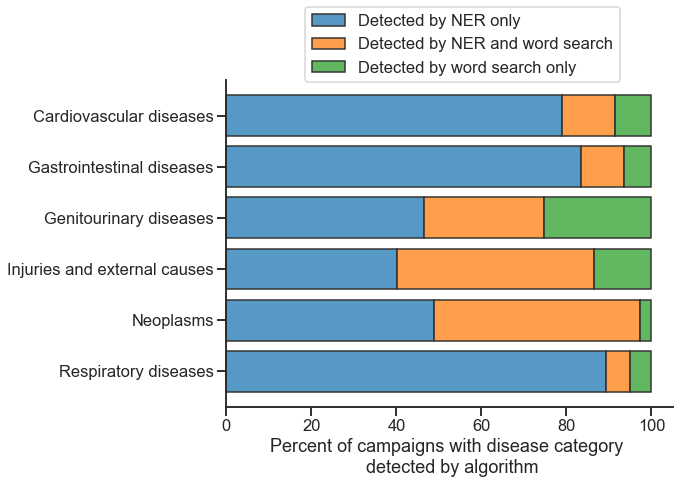

In [116]:
sns.set(style='ticks')
sns.set_context('talk', font_scale=1)
plt.figure(figsize=(8, 6))

#pal = {'Detected by NER model and word search':sns.color_palette('Blues')[1],'Detected by word search only':sns.color_palette('Blues')[5]}

pal = {'Detected by NER and word search':sns.color_palette('tab10')[1],
       'Detected by word search only':sns.color_palette('tab10')[2],
      'Detected by NER only':sns.color_palette('tab10')[0]}

ax = sns.histplot(base_merge_ct, 
                  y='disease_category', 
                  hue='sum', 
                  weights='value',
                  multiple='stack', 
                  shrink=0.8, 
                  edgecolor=".2", linewidth=1.5, palette=pal, legend=False)


plt.legend(labels = ['Detected by NER only', 'Detected by NER and word search','Detected by word search only'], bbox_to_anchor=(0.9,1.25))

ax.set_ylabel(None)
ax.set_xlabel('Percent of campaigns with disease category \n detected by algorithm')

sns.despine()

plt.savefig("../manuscripts/1 - METHODS/v6 - JMIR reviews/figure_2.eps", bbox_inches='tight')

# Figure 3: Co-occurrence of search results with NER results

In [117]:
#subset ER into algorithm and search term
#er_algo = er_final[~er_final['icd_10_cm_code'].str.contains('regex_search')]
#er_search = er_final[er_final['icd_10_cm_code'].str.contains('regex_search')]

In [118]:
#create pivot tables for each
er_algo_pivot = ER2Pivot(er_algo)
er_search_pivot = ER2Pivot(er_search)

In [119]:
#melt
er_algo_melt = pd.melt(er_algo_pivot, id_vars='url')
er_algo_melt.columns = ['url','cat','algo']

er_search_melt = pd.melt(er_search_pivot, id_vars='url')
er_search_melt.columns = ['url','cat','search']

In [120]:
#subset search results to include urls that also had disease identified by the algorithm
er_search_melt_overlap = er_search_melt[~er_search_melt['url'].isin(search_sub['url'].unique().tolist())]

In [121]:
#merge
coocc_merge = pd.merge(er_search_melt_overlap, er_algo_melt, on=['url'], how='left')

In [122]:
#subset to get overlapping disease categories
coocc_merge = coocc_merge[(coocc_merge['search'] == 1)&(coocc_merge['algo'] == 1)]

In [123]:
#reformat data
coocc_merge.head()
del coocc_merge['search']
del coocc_merge['algo']
coocc_merge.rename(columns={'cat_x':'search','cat_y':'algo'}, inplace=True)

In [124]:
#create crosstabulation
crosstab = pd.crosstab(coocc_merge['search'], coocc_merge['algo'])

In [114]:
# #create the following percentages:
# #among campaigns in which search terms found category R, what percent did NER find category Y

# #save crosstab columns
# crosstab_columns = crosstab.columns.tolist()

# #create columm for disease categories
# ct = crosstab.reset_index()
# ct.rename(columns={'search':'cat'}, inplace=True)

# #calculate number of campaigns in which search terms found category R
# found_by_search = er_search[['url','disease_category']].drop_duplicates()['disease_category'].value_counts().reset_index()
# found_by_search.rename(columns={'index':'cat','disease_category':'sum'}, inplace=True)

# #merge
# ct = ct.merge(found_by_search, on='cat')

# #divide
# ct[crosstab_columns] = round(ct[crosstab_columns].div(ct['sum'], axis=0) * 100)

# #reformat
# del ct['sum']
# ct.index = ct['cat']
# del ct['cat']
# ct = ct.astype(int)

# ct = ct.T

In [125]:
#save crosstab columns
crosstab =  crosstab.T
crosstab_columns = crosstab.columns.tolist()

In [126]:
ct = crosstab.reset_index()
ct.rename(columns={'algo':'cat'}, inplace=True)

In [127]:
#calculate number of campaigns in which search terms found category R
found_by_algo = er_algo[['url','disease_category']].drop_duplicates()['disease_category'].value_counts().reset_index()
found_by_algo.rename(columns={'index':'cat','disease_category':'sum'}, inplace=True)

#merge
ct = ct.merge(found_by_algo, on='cat')


In [128]:
#divide
ct[crosstab_columns] = round(ct[crosstab_columns].div(ct['sum'], axis=0) * 100)

#reformat
del ct['sum']
ct.index = ct['cat']
del ct['cat']
ct = ct.astype(int)

In [129]:
ct = ct.rename(index={'Mental and substance use disorders':'Mental health disorders'})

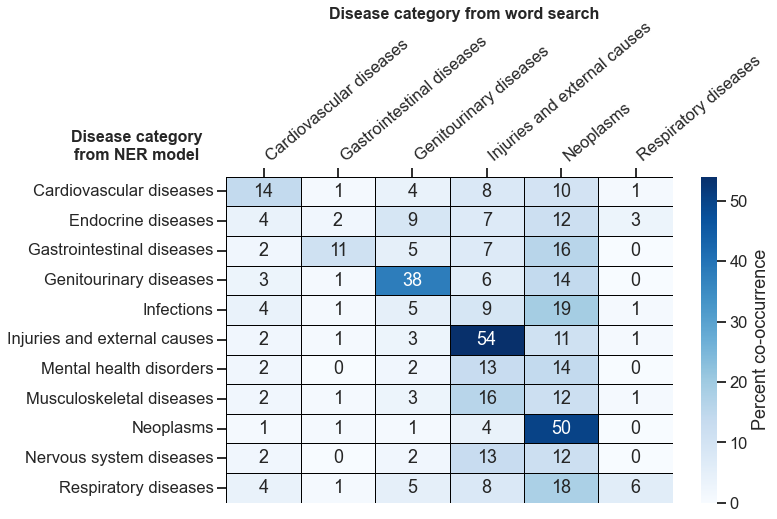

In [130]:
sns.set(style='ticks')
sns.set_context('talk', font_scale=1)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(ct, annot=True, 
            fmt='g',
            cbar_kws = {'label':'Percent co-occurrence'}, 
            linewidths=1, linecolor='black', cmap="Blues")
ax.set(ylabel=None)

ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.xticks(rotation=40, horizontalalignment='left')

plt.text(0.0005, 0.93, 
         'Disease category\nfrom NER model\n', 
         fontsize=16, 
         fontweight='bold', 
         #fontfamily='Helvetica',
         ha='center',
         va='center',
         transform=plt.gcf().transFigure)
plt.text(0.455, 1.255, 
         'Disease category from word search', 
         fontsize=16, 
         fontweight='bold', 
         #fontfamily='Helvetica',
         ha='center',
         va='center',
         transform=plt.gcf().transFigure)

plt.savefig("../manuscripts/1 - METHODS/v6 - JMIR reviews/figure_3.eps", bbox_inches='tight')

# Multimedia Appendix 5: Contribution of individual search terms

In [131]:
#campaigns that had word search results and algo results
er_search_melt_overlap.head()

,url,cat,search
0,https://www.gofundme.com/f/-MasonStrong-,Cardiovascular diseases,0
1,https://www.gofundme.com/f/-Shelby-Slaughter,Cardiovascular diseases,0
2,https://www.gofundme.com/f/-helpmario,Cardiovascular diseases,0
3,https://www.gofundme.com/f/-morganstrong,Cardiovascular diseases,0
4,https://www.gofundme.com/f/08312017roxies-medi...,Cardiovascular diseases,0


In [132]:
er_search_algo_overlap = search_results_df[search_results_df['url'].isin(er_search_melt_overlap['url'].unique().tolist())]

In [133]:
er_search_algo_overlap[['url','disease_category']].drop_duplicates()['disease_category'].value_counts()

Neoplasms                       19079
Injuries and external causes     9238
Genitourinary diseases           2086
Cardiovascular diseases          1919
Gastrointestinal diseases         648
Respiratory diseases              440
Name: disease_category, dtype: int64

In [134]:
er_search_algo_overlap[['url','chunks']].drop_duplicates()['chunks'].value_counts()

chemo                     9670
chemotherapy              9649
radiation                 8602
accident                  4924
injuries                  3118
injury                    3086
dialysis                  1778
heart surgery             1490
injured                   1411
bone marrow transplant    1012
kidney transplant          871
liver transplant           648
heart transplant           527
burns                      503
lung transplant            440
crash                      355
burn                       324
burned                     280
collision                  203
radiotherapy                62
renal transplant             2
Name: chunks, dtype: int64

In [135]:
er_search_algo_overlap[er_search_algo_overlap['chunks'].str.contains('injury|injuries|injured')]['url'].nunique()

6491

In [136]:
er_search_algo_overlap[er_search_algo_overlap['chunks'].str.contains('burn|burns|burned')]['url'].nunique()

865

In [137]:
er_search_algo_overlap[er_search_algo_overlap['chunks'].str.contains('chemo|chemotherapy')]['url'].nunique()

16952

In [138]:
er_search_algo_overlap[er_search_algo_overlap['chunks'].str.contains('radiation|radiotherapy')]['url'].nunique()

8649

In [139]:
er_search_algo_overlap[er_search_algo_overlap['chunks'].str.contains('kidney transplant|renal transplant')]['url'].nunique()

873

In [140]:
mm_app_4_right = pd.DataFrame([
    {'word':'accident','count':4924, 'cat':'Injuries and external causes'},
    {'word':'injury/injuries/injured','count':6491, 'cat':'Injuries and external causes'},
    {'word':'crash','count':355, 'cat':'Injuries and external causes'},
    {'word':'collision','count':203, 'cat':'Injuries and external causes'},
    {'word':'burn/burns/burned','count':865, 'cat':'Injuries and external causes'},
    {'word':'heart transplant','count':527, 'cat':'Cardiovascular diseases'},
    {'word':'heart surgery','count':1490, 'cat':'Cardiovascular diseases'},
    {'word':'chemo/chemotherapy','count':16952, 'cat':'Neoplasms'},
    {'word':'radiation/radiotherapy','count':8649, 'cat':'Neoplasms'},
    {'word':'bone marrow transplant','count':1012, 'cat':'Neoplasms'},
    {'word':'dialysis','count':1778, 'cat':'Genitourinary diseases'},
    {'word':'kidney/renal transplant','count':873, 'cat':'Genitourinary diseases'},
    {'word':'liver transplant','count':648, 'cat':'Gastrointestinal diseases'},
    {'word':'lung transplant','count':440, 'cat':'Respiratory diseases'},
])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


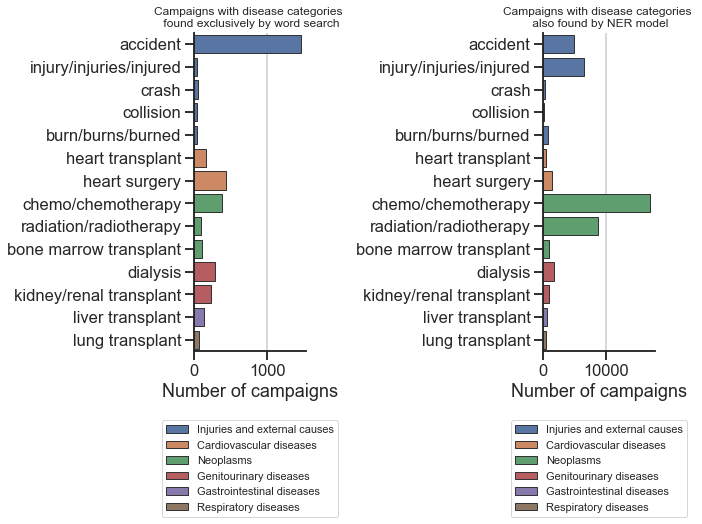

In [141]:
fig, axes = plt.subplots(1,2, figsize = (10,8))


sns.set(style="ticks")
sns.barplot(y='word', x='count', data=mm_app_4_left, hue='cat', edgecolor=".2", dodge=False, ax=axes[0])
axes[0].set_xlabel('Number of campaigns')
axes[0].set_title('')
axes[0].xaxis.grid(True)
axes[0].set_axisbelow(True)
axes[0].set_ylabel('')
axes[0].set_title('Campaigns with disease categories \n found exclusively by word search')

axes[0].legend(title='',
          bbox_to_anchor=(0.5, -0.2), loc='upper center')

plt.tight_layout(pad=3)
sns.despine()


sns.set(style="ticks")
sns.barplot(y='word', x='count', data=mm_app_4_right, hue='cat', edgecolor=".2", dodge=False, ax=axes[1])
axes[1].set_xlabel('Number of campaigns')
axes[1].set_title('')
axes[1].xaxis.grid(True)
axes[1].set_axisbelow(True)
axes[1].set_ylabel('')
axes[1].set_title('Campaigns with disease categories \n also found by NER model')

axes[1].legend(title='',
          bbox_to_anchor=(0.5, -0.2), loc='upper center')

plt.tight_layout(pad=3)
sns.despine()



plt.savefig("../manuscripts/1 - METHODS/v6 - JMIR reviews/multimedia_appendix_5.eps", bbox_inches='tight')

# Multimedia Appendix 8: Examples of false positive and false negative

In [142]:
d = {
    'cat': [],
    'error': [],
    'url': []
}

for col in sub.columns[2:]:
    r = ref[col]
    s = sub[col]
    for i in range(len(r)):
        url = sub['url'].tolist()[i]
        if r[i] == s[i]:
            continue
        else:
            if r[i] == 1:
                d['cat'].append(col)
                d['url'].append(url)
                d['error'].append('fn')
            elif s[i] == 1:
                d['cat'].append(col)
                d['url'].append(url)
                d['error'].append('fp')               

In [143]:
errors = pd.DataFrame(d)

In [144]:
errors[errors['cat'] == 'Cardiovascular diseases']

,cat,error,url
0,Cardiovascular diseases,fn,https://www.gofundme.com/f/1r2o2wloc0
1,Cardiovascular diseases,fp,https://www.gofundme.com/f/2t4nqbuk
2,Cardiovascular diseases,fn,https://www.gofundme.com/f/782ve85w
3,Cardiovascular diseases,fp,https://www.gofundme.com/f/7t39wo
4,Cardiovascular diseases,fn,https://www.gofundme.com/f/9m47v-heart-surgery...
5,Cardiovascular diseases,fn,https://www.gofundme.com/f/ArtValdez
6,Cardiovascular diseases,fn,https://www.gofundme.com/f/TheLoveofHisLife
7,Cardiovascular diseases,fn,https://www.gofundme.com/f/brian039s-legs
8,Cardiovascular diseases,fn,https://www.gofundme.com/f/chris039-battle-wit...
9,Cardiovascular diseases,fn,https://www.gofundme.com/f/enrud-jay039s-road-...


In [145]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/2t4nqbuk')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
28624,https://www.gofundme.com/f/2t4nqbuk,Spina Bifida,398.0,409.0,5.0,M4310,M4310:::M4309:::Q208:::M4307:::M479:::M4305:::...,spondylolisthesis:::spondylolysis:::cor bilocu...,10.6100:::10.8671:::10.8755:::11.0088:::11.045...,M4310,Spondylopathies/spondyloarthropathy (including...,Musculoskeletal diseases,NaN,NaN,NaN,"Spondylolisthesis, site unspecified",NaN
28625,https://www.gofundme.com/f/2t4nqbuk,neural tube defects,545.0,563.0,6.0,Q079,Q079:::Q795:::Q828:::Q899:::Q740:::Q824:::Q528...,neural tube defect:::congenital umbilical defe...,2.8952:::7.8109:::8.1516:::8.5853:::8.6087:::8...,Q079,Nervous system congenital anomalies,Nervous system diseases,NaN,NaN,NaN,"Congenital malformation of nervous system, uns...",NaN
28626,https://www.gofundme.com/f/2t4nqbuk,heart breaking,3692.0,3705.0,37.0,I469,I469:::I219:::I233:::T825:::R58:::S2690:::I258...,sinus arrest:::rupture of heart:::rupture of h...,9.4391:::9.4467:::9.5333:::9.5503:::9.7490:::9...,I469,Cardiac arrest and ventricular fibrillation,Cardiovascular diseases,NaN,NaN,NaN,"Cardiac arrest, cause unspecified",NaN


In [146]:
master[master['url'].str.contains('https://www.gofundme.com/f/2t4nqbuk')]['fund_description'].tolist()[0]

"Hello everyone, My name is Nicole Manzolli. I am creating this page for my very close friends Kayleigh and Anthony Goldberg.  They were high school sweethearts and got married October 10, 2014.  Soon after they became first time homeowners.  Kayleigh and Tony welcomed a beautiful baby girl, Ryleigh Ann Goldberg, into the world on May 24, 2016.  Before Ryleigh was born they were informed she had Spina Bifida affecting her lower spine but were not sure the severity until she was born.  Spina Bifida is part of a group of birth defects called neural tube defects. The neural tube is the embryonic structure that eventually develops into the baby's brain and spinal cord and the tissues that enclose them.  They found out when Kayleigh was 18 weeks pregnant and she had specialized neurosurgeon care at Yale New Haven Hospital since then.  Ryleigh went through her first MRI while she was still in utero.  Kayleigh needed to undergo a scheduled cesarean section because natural birth was too danger

In [147]:
master[master['url'].str.contains('https://www.gofundme.com/f/shdfppva')]['fund_description'].tolist()[0]

'My family and I are creating this to help out Jason Sisk.  Jason had an aortic dissection about a week ago.  He was taken to the hospital and then flown to St. Vincent Hospital in Indianapolis for emergency surgery.  Jason is a 14 year Army veteran with 4 tours of duty in Iraq.  Our goal is to help him and his family with general and holiday expenses while he is recovering.  We would like to present them with a donation on the 23rd of December if possible.  My family and I would greatly appreciate any help you could lend in this time of need.  Please donate if you can.   Merry Christmas and God bless.'

In [148]:
errors[errors['cat'] == 'Endocrine diseases']

,cat,error,url
26,Endocrine diseases,fp,https://www.gofundme.com/f/1qcndkejw0
27,Endocrine diseases,fn,https://www.gofundme.com/f/1zk33nyftc
28,Endocrine diseases,fn,https://www.gofundme.com/f/2nsxxjng
29,Endocrine diseases,fn,https://www.gofundme.com/f/barry039s-medical-fees
30,Endocrine diseases,fp,https://www.gofundme.com/f/bubblegirlali
31,Endocrine diseases,fn,https://www.gofundme.com/f/dau1k8
32,Endocrine diseases,fn,https://www.gofundme.com/f/fundsforalana
33,Endocrine diseases,fn,https://www.gofundme.com/f/jnjdbm4k
34,Endocrine diseases,fp,https://www.gofundme.com/f/jordynsjourney
35,Endocrine diseases,fn,https://www.gofundme.com/f/percy-stamps-on-my-...


In [149]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/please-help-karens-')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
11304,https://www.gofundme.com/f/please-help-karens-...,food allergies,372.0,385.0,2.0,T781,T781:::T781X:::Z9101:::Z9102:::Z910:::K522:::Z...,food allergy:::allergy to food:::food allergy ...,2.6654:::4.4447:::4.5697:::5.2001:::5.5752:::5...,T781,Allergic reactions,Injuries and external causes,4.0,4.0,0.0,best_match,NaN
11305,https://www.gofundme.com/f/please-help-karens-...,damage,1324.0,1329.0,8.0,T6591,T6591:::T1490:::T659:::Z789:::T415:::R238:::R6...,toxicity:::injury:::toxic effect:::toxic state...,6.3551:::6.7314:::6.8225:::6.8229:::7.1029:::7...,T6591,Poisoning/toxic effect/adverse effects/underdo...,Injuries and external causes,5.0,5.0,0.0,best_match,NaN
11306,https://www.gofundme.com/f/please-help-karens-...,food allergies,3087.0,3100.0,20.0,T781,T781:::T781X:::Z9101:::Z9102:::Z910:::K522:::Z...,food allergy:::allergy to food:::food allergy ...,2.6654:::4.4447:::4.5697:::5.2001:::5.5752:::5...,T781,Allergic reactions,Injuries and external causes,4.0,4.0,0.0,best_match,NaN
11307,https://www.gofundme.com/f/please-help-karens-...,food allergies,4165.0,4178.0,28.0,T781,T781:::T781X:::Z9101:::Z9102:::Z910:::K522:::Z...,food allergy:::allergy to food:::food allergy ...,2.6654:::4.4447:::4.5697:::5.2001:::5.5752:::5...,T781,Allergic reactions,Injuries and external causes,4.0,4.0,0.0,best_match,NaN
26427,https://www.gofundme.com/f/please-help-karens-...,mental illness,154.0,167.0,0.0,F99,F99:::F989:::Z818:::F069:::F489:::F818:::R4182...,mental illness:::mental disease:::fh - mental ...,0.0000:::4.2922:::6.1046:::6.4576:::6.6951:::6...,F99,Miscellaneous mental and behavioral disorders/...,Mental and substance use disorders,NaN,NaN,NaN,"Mental disorder, not otherwise specified",NaN
26428,https://www.gofundme.com/f/please-help-karens-...,infection,350.0,358.0,2.0,P399,P399:::B99:::P369:::B999:::H6039:::B889:::K137...,infection:::infectious disease:::clinical infe...,0.0000:::7.7580:::8.0403:::8.0569:::8.2141:::8...,P399,Perinatal infections,Infections,NaN,NaN,NaN,"Infection specific to the perinatal period, un...",NaN
26429,https://www.gofundme.com/f/please-help-karens-...,mental illness,412.0,425.0,2.0,F99,F99:::F989:::Z818:::F069:::F489:::F818:::R4182...,mental illness:::mental disease:::fh - mental ...,0.0000:::4.2922:::6.1046:::6.4576:::6.6951:::6...,F99,Miscellaneous mental and behavioral disorders/...,Mental and substance use disorders,NaN,NaN,NaN,"Mental disorder, not otherwise specified",NaN
26430,https://www.gofundme.com/f/please-help-karens-...,infection,566.0,574.0,3.0,P399,P399:::B99:::P369:::B999:::H6039:::B889:::K137...,infection:::infectious disease:::clinical infe...,0.0000:::7.7580:::8.0403:::8.0569:::8.2141:::8...,P399,Perinatal infections,Infections,NaN,NaN,NaN,"Infection specific to the perinatal period, un...",NaN
26431,https://www.gofundme.com/f/please-help-karens-...,paranoia,618.0,625.0,4.0,F22,F22:::F195:::F105:::R470:::R202:::R413:::G4741...,paranoia:::drug induced paranoia:::alcohol ind...,0.0000:::7.3859:::7.7198:::7.8706:::8.1753:::8...,F22,Schizophrenia spectrum and other psychotic dis...,Mental and substance use disorders,NaN,NaN,NaN,Delusional disorders,NaN
26432,https://www.gofundme.com/f/please-help-karens-...,mania,628.0,632.0,4.0,F309,F309:::F302:::F30:::R468:::F388:::F063:::F318:...,mania:::manic mood:::manic episode:::manic beh...,0.0000:::5.2227:::6.7298:::6.8568:::8.4662:::8...,F309,Bipolar and related disorders,Mental and substance use disorders,NaN,NaN,NaN,"Manic episode, unspecified",NaN


In [150]:
master[master['url'].str.contains('https://www.gofundme.com/f/please-help-karens')]['fund_description'].tolist()[0]

'Help save my daughter\'s healthImagine having a normal child and all of a sudden having your world turned upside down when they develop symptoms of severe mental illness. This has been the story of our lives for the last 3 years. My oldest daughter we discovered (through many hours or research on my part) has a medical problem, a chronic and severe infection, as well as food allergies, which cause SYMPTOMS of mental illness. Even though I have determined the medical cause for her symptoms, we still had to deal with the SYMPTOMS that manifest as a result of the infection. I won\'t mention all, but some are severe paranoia, mania, delusions, depression, suicidal ideations, insomnia, and psychosis. Not to mention all the side effects from the psychiatric drugs she has been on to "stabilize."We are very close to our daughter and when she gets in these states of mind, we are the enemy and getting her to do what she needs to do is EXTREMELY challenging. But when she can come out of those st

In [151]:
master[master['url'].str.contains('https://www.gofundme.com/f/dau1k8')]['fund_description'].tolist()[0]

"As many of you know from Facebook, Lindsay was diagnosed with thyroid cancer in June of 2013. Her type of thyroid cancer, tall cell papillary carcinoma with BRAF mutation, is a type with two mutations in the gene which makes it harder to treat. Lindsay originally went to the Cleveland Clinic for surgery to remove her thyroid after a diagnosis with Graves' disease. At the time she did not know she had cancer. Since her diagnosis she has had two additional surgeries in the last year. The most recent was in May 2014. They have now determined that her cancer has mestatisized to beneath collar bone, making treatment even more difficult. At this time the doctors at Cleveland Clinic can not come to an agreement on what the next steps should be.At 33 years old and with two young children at home, one with Autism, Lindsay would like to seek a second opinion. However, as of the end of last school year Lindsay is unemployed and her insurance is refusing to pay any additional medical bills. That 

In [152]:
errors[errors['cat'] == 'Gastrointestinal diseases']

,cat,error,url
37,Gastrointestinal diseases,fn,https://www.gofundme.com/f/20tm9hel9c
38,Gastrointestinal diseases,fp,https://www.gofundme.com/f/22kcir7teo
39,Gastrointestinal diseases,fn,https://www.gofundme.com/f/9tjhwu-please-help
40,Gastrointestinal diseases,fn,https://www.gofundme.com/f/Gofundmecomliampels
41,Gastrointestinal diseases,fp,https://www.gofundme.com/f/baby-grace039s-road...
42,Gastrointestinal diseases,fp,https://www.gofundme.com/f/bubblegirlali
43,Gastrointestinal diseases,fn,https://www.gofundme.com/f/gjfsmo
44,Gastrointestinal diseases,fp,https://www.gofundme.com/f/h5xnpj-help-my-gran...
45,Gastrointestinal diseases,fn,https://www.gofundme.com/f/hwi21w
46,Gastrointestinal diseases,fn,https://www.gofundme.com/f/kljvs8


In [153]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/22kcir7teo')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
97843,https://www.gofundme.com/f/22kcir7teo,bacterial endocarditis,32.0,53.0,0.0,I330,I330:::I5189:::B999:::I38:::B3321:::I339:::L99...,bacterial endocarditis:::chronic bacterial end...,0.0000:::4.6061:::4.8192:::4.9805:::5.4328:::5...,I330,Endocarditis and endocardial disease,Cardiovascular diseases,NaN,NaN,NaN,Acute and subacute infective endocarditis,NaN
97845,https://www.gofundme.com/f/22kcir7teo,heart valves,99.0,110.0,0.0,I38,I38:::T826X:::Z9581:::Y712:::R012:::I519:::I51...,disorder of heart valve:::cardiac vegetation::...,8.7056:::8.7244:::9.2267:::9.3671:::9.5877:::9...,I38,Endocarditis and endocardial disease,Cardiovascular diseases,NaN,NaN,NaN,"Endocarditis, valve unspecified",NaN
97846,https://www.gofundme.com/f/22kcir7teo,infection pockets,151.0,167.0,1.0,K1379,K1379:::T857:::L089:::P394:::B999:::P399:::L02...,infection mouth:::pocket site infection:::infe...,8.7619:::8.9299:::9.5174:::9.6141:::9.9629:::1...,K1379,Diseases of mouth; excluding dental,Gastrointestinal diseases,NaN,NaN,NaN,Other lesions of oral mucosa,NaN
97847,https://www.gofundme.com/f/22kcir7teo,kidney failure,184.0,197.0,1.0,N19,N19:::P960:::P2930:::N189:::N17:::I120:::N139:...,renal failure:::rf - renal failure:::chronic r...,4.6801:::6.1022:::6.1869:::6.2823:::6.4674:::6...,N19,Acute and unspecified renal failure,Genitourinary diseases,NaN,NaN,NaN,Unspecified kidney failure,NaN
97848,https://www.gofundme.com/f/22kcir7teo,infection,250.0,258.0,1.0,P399,P399:::B99:::P369:::B999:::H6039:::B889:::K137...,infection:::infectious disease:::clinical infe...,0.0000:::7.7580:::8.0403:::8.0569:::8.2141:::8...,P399,Perinatal infections,Infections,NaN,NaN,NaN,"Infection specific to the perinatal period, un...",NaN
67781,https://www.gofundme.com/f/22kcir7teo,dialysis,236.0,244.0,NaN,regex_search,NaN,NaN,NaN,regex_search,GU_from_proc,Genitourinary diseases,NaN,NaN,NaN,dialysis,CKD and renal failure
67781,https://www.gofundme.com/f/22kcir7teo,heart surgery,718.0,731.0,NaN,regex_search,NaN,NaN,NaN,regex_search,CV_from_proc,Cardiovascular diseases,NaN,NaN,NaN,heart surgery,Other cardiovascular disorders


In [154]:
master[master['url'].str.contains('https://www.gofundme.com/f/22kcir7teo')]['fund_description'].tolist()[0]

'I’m at centennial hospital with bacterial endocarditis, MRSA in my bloodstream, septic emboli, two heart valves with vegetation(clot) buildup on them, infection pockets in both lungs, kidney failure which caused me to have to be put on dialysis, and infection in my hip that’s so painful I can’t walk.. I  don’t have insurance and when I get out of here I’ve got to be able to afford 6 more weeks of iv antibiotic treatment at a clinic, dialysis at a dialysis clinic, follow up with a kidney doctor, and 7 weeks physical therapy. But if I can’t afford all of that then I’d either be dead in a few days or weeks at most, or best case scenario I’d have to get rushed back to the hospital to get an angiovac or have open heart surgery. If you could please help donate it I’d really appreciate it.. I hate asking but I really don’t have any other choice since I don’t have insurance and I’m stuck here so I can’t work..'

In [155]:
master[master['url'].str.contains('https://www.gofundme.com/f/hwi21w')]['fund_description'].tolist()[0]

'Hello Friends,We are Linda’s family and we are writing this on her behalf. Many of you know she recently traveled for a leisurely trip to visit friends in Nicaragua as she has done in the past. While she was there, she had multiple emergency surgeries stemming from an ulcer. She has had complications healing in a timely manner. She is currently stuck in a free hospital in a 3rd world country unable to move from her bed, let alone travel. We have been on a rollercoaster ride of hope and despair on a daily basis. We speak to the US Embassy as well as the hospital every day. We have sent food, care packages, however she has not been able to keep anything down for a month.  She has a catheter and needs assistance to even sit up. We will spare you with the details that have been conveyed to us over the last month.As we all reflect on thoughts of gratitude this evening, we find gratitude in this dark moment and send mom positive thoughts. This is not how we ever hoped to spend our Thanksgiv

In [156]:
errors[errors['cat'] == 'Genitourinary diseases']

,cat,error,url
53,Genitourinary diseases,fn,https://www.gofundme.com/f/5pbs50
54,Genitourinary diseases,fn,https://www.gofundme.com/f/cancer-bill-and-exp...
55,Genitourinary diseases,fn,https://www.gofundme.com/f/help-megan-fix-her-...
56,Genitourinary diseases,fn,https://www.gofundme.com/f/i2hr7g
57,Genitourinary diseases,fn,https://www.gofundme.com/f/jazerispath
58,Genitourinary diseases,fn,https://www.gofundme.com/f/miles039-service-do...
59,Genitourinary diseases,fp,https://www.gofundme.com/f/please-help-karens-...
60,Genitourinary diseases,fn,https://www.gofundme.com/f/superzane


In [157]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/please-help-karens-')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
11304,https://www.gofundme.com/f/please-help-karens-...,food allergies,372.0,385.0,2.0,T781,T781:::T781X:::Z9101:::Z9102:::Z910:::K522:::Z...,food allergy:::allergy to food:::food allergy ...,2.6654:::4.4447:::4.5697:::5.2001:::5.5752:::5...,T781,Allergic reactions,Injuries and external causes,4.0,4.0,0.0,best_match,NaN
11305,https://www.gofundme.com/f/please-help-karens-...,damage,1324.0,1329.0,8.0,T6591,T6591:::T1490:::T659:::Z789:::T415:::R238:::R6...,toxicity:::injury:::toxic effect:::toxic state...,6.3551:::6.7314:::6.8225:::6.8229:::7.1029:::7...,T6591,Poisoning/toxic effect/adverse effects/underdo...,Injuries and external causes,5.0,5.0,0.0,best_match,NaN
11306,https://www.gofundme.com/f/please-help-karens-...,food allergies,3087.0,3100.0,20.0,T781,T781:::T781X:::Z9101:::Z9102:::Z910:::K522:::Z...,food allergy:::allergy to food:::food allergy ...,2.6654:::4.4447:::4.5697:::5.2001:::5.5752:::5...,T781,Allergic reactions,Injuries and external causes,4.0,4.0,0.0,best_match,NaN
11307,https://www.gofundme.com/f/please-help-karens-...,food allergies,4165.0,4178.0,28.0,T781,T781:::T781X:::Z9101:::Z9102:::Z910:::K522:::Z...,food allergy:::allergy to food:::food allergy ...,2.6654:::4.4447:::4.5697:::5.2001:::5.5752:::5...,T781,Allergic reactions,Injuries and external causes,4.0,4.0,0.0,best_match,NaN
26427,https://www.gofundme.com/f/please-help-karens-...,mental illness,154.0,167.0,0.0,F99,F99:::F989:::Z818:::F069:::F489:::F818:::R4182...,mental illness:::mental disease:::fh - mental ...,0.0000:::4.2922:::6.1046:::6.4576:::6.6951:::6...,F99,Miscellaneous mental and behavioral disorders/...,Mental and substance use disorders,NaN,NaN,NaN,"Mental disorder, not otherwise specified",NaN
26428,https://www.gofundme.com/f/please-help-karens-...,infection,350.0,358.0,2.0,P399,P399:::B99:::P369:::B999:::H6039:::B889:::K137...,infection:::infectious disease:::clinical infe...,0.0000:::7.7580:::8.0403:::8.0569:::8.2141:::8...,P399,Perinatal infections,Infections,NaN,NaN,NaN,"Infection specific to the perinatal period, un...",NaN
26429,https://www.gofundme.com/f/please-help-karens-...,mental illness,412.0,425.0,2.0,F99,F99:::F989:::Z818:::F069:::F489:::F818:::R4182...,mental illness:::mental disease:::fh - mental ...,0.0000:::4.2922:::6.1046:::6.4576:::6.6951:::6...,F99,Miscellaneous mental and behavioral disorders/...,Mental and substance use disorders,NaN,NaN,NaN,"Mental disorder, not otherwise specified",NaN
26430,https://www.gofundme.com/f/please-help-karens-...,infection,566.0,574.0,3.0,P399,P399:::B99:::P369:::B999:::H6039:::B889:::K137...,infection:::infectious disease:::clinical infe...,0.0000:::7.7580:::8.0403:::8.0569:::8.2141:::8...,P399,Perinatal infections,Infections,NaN,NaN,NaN,"Infection specific to the perinatal period, un...",NaN
26431,https://www.gofundme.com/f/please-help-karens-...,paranoia,618.0,625.0,4.0,F22,F22:::F195:::F105:::R470:::R202:::R413:::G4741...,paranoia:::drug induced paranoia:::alcohol ind...,0.0000:::7.3859:::7.7198:::7.8706:::8.1753:::8...,F22,Schizophrenia spectrum and other psychotic dis...,Mental and substance use disorders,NaN,NaN,NaN,Delusional disorders,NaN
26432,https://www.gofundme.com/f/please-help-karens-...,mania,628.0,632.0,4.0,F309,F309:::F302:::F30:::R468:::F388:::F063:::F318:...,mania:::manic mood:::manic episode:::manic beh...,0.0000:::5.2227:::6.7298:::6.8568:::8.4662:::8...,F309,Bipolar and related disorders,Mental and substance use disorders,NaN,NaN,NaN,"Manic episode, unspecified",NaN


In [158]:
master[master['url'].str.contains('https://www.gofundme.com/f/please-help-karens-')]['fund_description'].tolist()[0]

'Help save my daughter\'s healthImagine having a normal child and all of a sudden having your world turned upside down when they develop symptoms of severe mental illness. This has been the story of our lives for the last 3 years. My oldest daughter we discovered (through many hours or research on my part) has a medical problem, a chronic and severe infection, as well as food allergies, which cause SYMPTOMS of mental illness. Even though I have determined the medical cause for her symptoms, we still had to deal with the SYMPTOMS that manifest as a result of the infection. I won\'t mention all, but some are severe paranoia, mania, delusions, depression, suicidal ideations, insomnia, and psychosis. Not to mention all the side effects from the psychiatric drugs she has been on to "stabilize."We are very close to our daughter and when she gets in these states of mind, we are the enemy and getting her to do what she needs to do is EXTREMELY challenging. But when she can come out of those st

In [159]:
master[master['url'].str.contains('https://www.gofundme.com/f/jazerispath')]['fund_description'].tolist()[0]

'Jazeri Comstock is a recent graduate of North Cobb High School in Kennesaw, Georgia. Not only is she the most kind-hearted, strong girl you will ever meet, she is also a competitve cheerleader and varsity lacrosse player. Recently this summer, Jazeri  had several oral surgeries due to a huge mishap while getting her wisdom teeth removed. An infection broke out and her kidneys are unable to fight off the infections as needed, and are slowly shutting down. Jazeri was quickly diagnosed with acute leukemia. She is fighting harder than ever, but we need your help to get her back to feeling better than ever. Thank you so much for your support!'

In [162]:
errors[errors['cat'] == 'Infections']

,cat,error,url
61,Infections,fp,https://www.gofundme.com/f/2fpqy-it-takes-a-vi...
62,Infections,fp,https://www.gofundme.com/f/500i5k0
63,Infections,fp,https://www.gofundme.com/f/5pbs50
64,Infections,fp,https://www.gofundme.com/f/650z2eo
65,Infections,fp,https://www.gofundme.com/f/Gofundmecomliampels
66,Infections,fp,https://www.gofundme.com/f/cathy-lennartz
67,Infections,fp,https://www.gofundme.com/f/clp5ms
68,Infections,fp,https://www.gofundme.com/f/e32q7s
69,Infections,fn,https://www.gofundme.com/f/fight-matty-fight
70,Infections,fp,https://www.gofundme.com/f/fighting-brain-canc...


In [163]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/650z2eo')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
84494,https://www.gofundme.com/f/650z2eo,morbidly obese,12.0,25.0,0.0,E668,E668:::Z6841:::E6601:::E349:::E669:::E66:::O99...,obese build:::obese:::morbid obesity:::severe ...,4.2761:::4.5766:::4.8204:::4.9337:::4.9593:::6...,E668,Obesity,Endocrine diseases,NaN,NaN,NaN,Other obesity,NaN
84495,https://www.gofundme.com/f/650z2eo,obese,165.0,169.0,3.0,Z6841,Z6841:::E668:::E669:::E6601:::E66:::E349:::Q13...,obese:::obese build:::obese abdomen:::morbid o...,0.0000:::2.6862:::3.9285:::5.1331:::5.4360:::5...,Z6841,Obesity,Endocrine diseases,NaN,NaN,NaN,"Body mass index [BMI]40.0-44.9, adult",NaN
84496,https://www.gofundme.com/f/650z2eo,sickness,357.0,364.0,7.0,B349,B349:::B608:::R6889:::R69:::R4589:::R457:::M79...,sickness:::turning sickness:::distress:::illne...,0.0000:::7.3594:::7.6824:::7.7172:::7.9534:::7...,B349,Viral infection,Infections,NaN,NaN,NaN,"Viral infection, unspecified",NaN
84497,https://www.gofundme.com/f/650z2eo,super obese,432.0,442.0,7.0,Z6841,Z6841:::E349:::E668:::E669:::E6601:::H3550:::Q...,obese:::severe obesity:::obese build:::obese a...,4.6781:::4.8988:::4.9270:::5.3864:::6.1031:::6...,Z6841,Obesity,Endocrine diseases,NaN,NaN,NaN,"Body mass index [BMI]40.0-44.9, adult",NaN


In [164]:
master[master['url'].str.contains('https://www.gofundme.com/f/650z2eo')]['fund_description'].tolist()[0]

"I have been morbidly obese for the majority of my life. When I was a young child, a tragic evil act was done upon me. My coping mechanism became food. I became very obese quickly. By 16 years old I was over 400 lbs. My addiction to food robbed me of my childhood. I never got to play sports, go to dances and experience many of the fun events like that. My sickness continued into adulthood, my weight became a deadly 555 lbs I was super obese. My clothing size was a 9xl. I was forced to order clothes from a catalog because the local big and tall didn't go to that size. Going out in public, fitting into chairs was a living nightmare. 3 and half years ago, I finally took control of my life. I began walking, eating healthier and joined a gym. To date I have lost over 300 lbs and I am down to a 1xl. I can't begin to describe how difficult and at times seemed impossible this journey has been. As a result of my massive weight loss, I have a huge layer of skin over my stomach, groin, and thigh 

In [165]:
master[master['url'].str.contains('https://www.gofundme.com/f/fight-matty-fight')]['fund_description'].tolist()[0]

'On Friday, September 7th, Matthew Crosby (Matty) had an unfortunate accident while working.  He suffered severe injuries resulting in a substantial amount of internal bleeding. Many blood transfusions later the doctors at Venice Regional Bayfront Hospital determined it would be best to transfer him via helicopter to a Trauma hospital in hopes to better accommodate his critical condition.  Tampa and Sarasota Hospital denied the request for transport because they believed it would be too risky and  he ultimately would not make it. The doctors at Venice Regional Bayfront Hospital stated he only had a matter of hours left to live. There was one option left but his outlook would be very poor. They would open his chest cavity in hopes to find the source of bleeding.  With Matt losing blood faster then he was receiving it the doctors explained to us that the surgery was a  "hail mary" attempt to save his life. We wanted them to do all they could to save Matty so we agreed to the surgery. Bei

In [166]:
errors[errors['cat'] == 'Injuries and external causes']

,cat,error,url
86,Injuries and external causes,fn,https://www.gofundme.com/f/5pbs50
87,Injuries and external causes,fp,https://www.gofundme.com/f/AmberandEmily
88,Injuries and external causes,fp,https://www.gofundme.com/f/Gofundmecomliampels
89,Injuries and external causes,fp,https://www.gofundme.com/f/Healing-Kathy-Worley
90,Injuries and external causes,fp,https://www.gofundme.com/f/Xavier-s-Battle-Wit...
91,Injuries and external causes,fp,https://www.gofundme.com/f/arlene-toy-is-battl...
92,Injuries and external causes,fp,https://www.gofundme.com/f/b4sj7bfy
93,Injuries and external causes,fn,https://www.gofundme.com/f/barry039s-medical-fees
94,Injuries and external causes,fp,https://www.gofundme.com/f/billsmedfund
95,Injuries and external causes,fp,https://www.gofundme.com/f/bre039s-transplant


In [167]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/AmberandEmily')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
75914,https://www.gofundme.com/f/AmberandEmily,Lyme disease,81.0,92.0,0.0,A692,A692:::Z0389:::A6929:::A6923:::A6920:::Z861:::...,lyme disease:::suspected lyme disease:::skelet...,3.7696:::6.2951:::7.3665:::7.9195:::9.0836:::9...,A692,"Parasitic, other specified and unspecified inf...",Infections,4.0,4.0,0.0,best_match,NaN
75915,https://www.gofundme.com/f/AmberandEmily,Lyme disease,268.0,279.0,2.0,A692,A692:::Z0389:::A6929:::A6923:::A6920:::Z861:::...,lyme disease:::suspected lyme disease:::skelet...,3.7696:::6.2951:::7.3665:::7.9195:::9.0836:::9...,A692,"Parasitic, other specified and unspecified inf...",Infections,4.0,4.0,0.0,best_match,NaN
75916,https://www.gofundme.com/f/AmberandEmily,tick bite,803.0,811.0,6.0,T140,T140:::T6348:::B999:::W57XX:::X25:::T634:::B88...,tick bite:::bite of tick:::infection of tick b...,0.0000:::4.6562:::5.3680:::6.3509:::9.9131:::1...,T140,Other unspecified injury,Injuries and external causes,4.0,3.0,1.0,best_match,NaN
75917,https://www.gofundme.com/f/AmberandEmily,migraines,2114.0,2122.0,14.0,G439,G439:::G4300:::G4390:::G4401:::G431:::G4310:::...,migraine:::common migraine:::migraine (disorde...,3.4151:::5.0040:::5.2596:::5.8001:::5.9409:::5...,G439,Headache; including migraine,Nervous system diseases,4.0,4.0,0.0,best_match,NaN
75918,https://www.gofundme.com/f/AmberandEmily,migraines,2779.0,2787.0,18.0,G439,G439:::G4300:::G4390:::G4401:::G431:::G4310:::...,migraine:::common migraine:::migraine (disorde...,3.4151:::5.0040:::5.2596:::5.8001:::5.9409:::5...,G439,Headache; including migraine,Nervous system diseases,4.0,4.0,0.0,best_match,NaN
75919,https://www.gofundme.com/f/AmberandEmily,Lyme disease,4234.0,4245.0,30.0,A692,A692:::Z0389:::A6929:::A6923:::A6920:::Z861:::...,lyme disease:::suspected lyme disease:::skelet...,3.7696:::6.2951:::7.3665:::7.9195:::9.0836:::9...,A692,"Parasitic, other specified and unspecified inf...",Infections,4.0,4.0,0.0,best_match,NaN
178275,https://www.gofundme.com/f/AmberandEmily,Lyme,610.0,613.0,5.0,F800,F800:::T6379:::L0242:::A539:::R943:::I898:::L0...,lalling (finding):::locoism:::furuncle of limb...,9.8033:::10.3104:::10.3526:::10.5330:::10.5342...,F800,Neurodevelopmental disorders,Mental and substance use disorders,NaN,NaN,NaN,Phonological disorder,NaN
178276,https://www.gofundme.com/f/AmberandEmily,sickness,750.0,757.0,5.0,B349,B349:::B608:::R6889:::R69:::R4589:::R457:::M79...,sickness:::turning sickness:::distress:::illne...,0.0000:::7.3594:::7.6824:::7.7172:::7.9534:::7...,B349,Viral infection,Infections,NaN,NaN,NaN,"Viral infection, unspecified",NaN
178278,https://www.gofundme.com/f/AmberandEmily,Fibromyalgia,911.0,922.0,7.0,M797,M797:::M7979:::M791:::M353:::R073:::B6981:::M7...,fibromyalgia:::fibromyalgia (disorder):::myalg...,2.8179:::4.5827:::7.6502:::8.0405:::8.5617:::8...,M797,Other specified connective tissue disease,Musculoskeletal diseases,NaN,NaN,NaN,Fibromyalgia,NaN
178279,https://www.gofundme.com/f/AmberandEmily,Lupus,925.0,929.0,7.0,A184,A184:::A502:::R2989:::G318:::L815:::L930:::I44...,lupus exedens:::luetic disease:::ludington sig...,10.2892:::10.3671:::10.5845:::10.7153:::10.722...,A184,Tuberculosis,Infections,NaN,NaN,NaN,Tuberculosis of skin and subcutaneous tissue,NaN


In [168]:
master[master['url'].str.contains('https://www.gofundme.com/f/AmberandEmily')]['fund_description'].tolist()[0]

"Our two daughters, Amber (16) and Emily (13), have a debilitating illness called Lyme disease. After two years of treatment in the US they are still very sick. In January 2017, we will travel to Germany where many Americans have experienced great results curing their Lyme disease, but it is extremely expensive. We have stepped out in faith because we are DESPERATE to get our girls well! The last few years of various treatments have been extremely expensive (insurance pays almost nothing), so we are now forced to fund raise to earn money for the trip…and to give our girls a new chance at a healthy life! Lyme is often known as the “invisible illness” due to the fact the patient may appear well on the outside but live with incredible pain and sickness on the inside. The disease is caused from a tick bite that goes untreated. It is very challenging to diagnose because it mimics other diseases, such as Fibromyalgia, Lupus, Chronic Fatigue, and Rheumatoid Arthritis, and blood tests frequent

In [169]:
master[master['url'].str.contains('https://www.gofundme.com/f/vpugwz-dentist-bill')]['fund_description'].tolist()[0]

"Hello friends and family. This past year has been a difficult one in the finance department. I left my previous job for ethical reasons a few months ago which led to no work for two weeks.  During that two week period I was offered some subcontracting work but that would mean I'd need to get my LLC (which cost a big chunk of money for being off work for the two weeks prior). About a month into doing subcontracting work and trying to get back up on our feet, I broke two teeth and was having severe pain in an already broken tooth. We don't have dental insurance but we decided to go for a consultation visit to our Dentist to talk about options and what it would cost for us to fix my teeth. We decided to go down the root canal option as to save my teeth. I got one root canal already, need to get one more, and need to get a filling in my 3rd broken tooth. We are left with a dental bill of a little over $6,000.00. We are really struggling to pay it and would ask that you prayerfully conside

In [171]:
errors[errors['cat'] == 'Mental health disorders']

,cat,error,url
112,Mental health disorders,fn,https://www.gofundme.com/f/234rrn40qo
113,Mental health disorders,fn,https://www.gofundme.com/f/3r332gm8
114,Mental health disorders,fp,https://www.gofundme.com/f/AmberandEmily
115,Mental health disorders,fp,https://www.gofundme.com/f/Denningfamily
116,Mental health disorders,fp,https://www.gofundme.com/f/Mary-sjourney
117,Mental health disorders,fp,https://www.gofundme.com/f/Support4Shannon
118,Mental health disorders,fp,https://www.gofundme.com/f/TeamDanica-Monica
119,Mental health disorders,fp,https://www.gofundme.com/f/addison-mae-potts
120,Mental health disorders,fp,https://www.gofundme.com/f/b4sj7bfy
121,Mental health disorders,fn,https://www.gofundme.com/f/chiverhood-auction-...


In [172]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/Support4Shannon')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
59152,https://www.gofundme.com/f/Support4Shannon,Blastic plasmacytoid dendritic cell neoplasm,69.0,112.0,0.0,C864,C864:::C9020:::C8510:::C833:::D479:::C8300:::C...,blastic plasmacytoid dendritic cell neoplasm::...,2.9827:::7.9390:::8.5666:::8.6719:::8.7589:::8...,C864,Non-Hodgkin lymphoma,Neoplasms,NaN,NaN,NaN,Blastic NK-cell lymphoma,NaN
59153,https://www.gofundme.com/f/Support4Shannon,BPDCN,115.0,119.0,0.0,F488,F488:::F448:::R2989:::Z7289:::Q898:::M1129:::M...,piblokto:::pibloktoq:::bayonet sign:::boozer::...,9.5335:::9.8650:::10.1425:::10.3270:::10.4943:...,F488,Miscellaneous mental and behavioral disorders/...,Mental and substance use disorders,NaN,NaN,NaN,Other specified nonpsychotic mental disorders,NaN
59154,https://www.gofundme.com/f/Support4Shannon,leukemia,600.0,607.0,4.0,C9590,C9590:::C959:::C9480:::C950:::C951:::C9190:::Z...,leukemia:::leukaemia:::aleukemic leukemia:::ac...,0.0000:::3.9547:::5.1825:::5.2947:::5.8066:::5...,C9590,Leukemia - all other types,Neoplasms,NaN,NaN,NaN,"Leukemia, unspecified not having achieved remi...",NaN
49791,https://www.gofundme.com/f/Support4Shannon,chemotherapy,181.0,193.0,NaN,regex_search,NaN,NaN,NaN,regex_search,NEO_from_proc,Neoplasms,NaN,NaN,NaN,chemotherapy,Other neoplasms
49791,https://www.gofundme.com/f/Support4Shannon,bone marrow transplant,297.0,319.0,NaN,regex_search,NaN,NaN,NaN,regex_search,NEO_from_proc,Neoplasms,NaN,NaN,NaN,bone marrow transplant,Other neoplasms


In [173]:
master[master['url'].str.contains('https://www.gofundme.com/f/Support4Shannon')]['fund_description'].tolist()[0]

"Shannon Heika is a beautiful 22 year old who was just diagnosed with Blastic plasmacytoid dendritic cell neoplasm (BPDCN) and now she's in a fight for her life. She began her first chemotherapy treatment on February 4th. Several cycles may be needed to get her into remission so she can receive a bone marrow transplant (donation drive info to follow). She graduated from Dakota High School in 2009 and then from University of Detroit Mercy with a degree in biology in 2013. She had just began her 2nd semester at Life University College of Chiropractic when she was diagnosed with this rare form of leukemia.Shannon is a fighter, but she needs a strong team behind her. Please help us relieve any financial pressures so she can concentrate on getting better and beating this horrible disease.Our current fundraising goals are to cover anything her insurance won't cover, travel expenses (she's currently in Atlanta until she's well enough to travel to Michigan), and a nice wig. Her student loans w

In [174]:
master[master['url'].str.contains('https://www.gofundme.com/f/234rrn40qo')]['fund_description'].tolist()[0]

'Hi, I’m Megan Mallory and I’ve been struggling with Bipolar Type 1 for over a year now. This year it hit me hard and I nearly lost my life. I had a severe manic episode that nearly cost me my life. I lost my home, my job that I loved, and was put in jail for 2+ months. Now I’m trying to keep my sanity and stay out of jail while the medical bills are piling up from 6X hospital stays. I’ve been told that I deserved everything that happened to me and it’s my fault. I didn’t choose to be sick. I wouldn’t wish this illness on anyone. It takes you over and destroys everything you love. Now I’m working hard to get it back. Please, any small amount would help. I want to get back to being a nurse again and helping people. It’s my calling in life.'

In [175]:
errors[errors['cat'] == 'Musculoskeletal diseases']

,cat,error,url
133,Musculoskeletal diseases,fp,https://www.gofundme.com/f/227uvehjeo
134,Musculoskeletal diseases,fn,https://www.gofundme.com/f/22kcir7teo
135,Musculoskeletal diseases,fn,https://www.gofundme.com/f/2bvdbh5a
136,Musculoskeletal diseases,fp,https://www.gofundme.com/f/2t4nqbuk
137,Musculoskeletal diseases,fn,https://www.gofundme.com/f/3r332gm8
138,Musculoskeletal diseases,fn,https://www.gofundme.com/f/5pbs50
139,Musculoskeletal diseases,fn,https://www.gofundme.com/f/650z2eo
140,Musculoskeletal diseases,fp,https://www.gofundme.com/f/7t39wo
141,Musculoskeletal diseases,fn,https://www.gofundme.com/f/86yp23-gregs-road-t...
142,Musculoskeletal diseases,fp,https://www.gofundme.com/f/89yriw


In [176]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/89yriw')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
161481,https://www.gofundme.com/f/89yriw,injuries,324.0,331.0,4.0,T1490,T1490:::T149:::T148X:::T888X:::T141:::T07XX:::...,injury:::accidental injury:::laceration - inju...,4.6239:::7.1750:::7.6451:::7.6914:::7.7568:::7...,T1490,Other unspecified injury,Injuries and external causes,NaN,NaN,NaN,"Injury, unspecified",NaN
161482,https://www.gofundme.com/f/89yriw,shattered pelvis,367.0,382.0,4.0,M955,M955:::S3281:::Q742:::S399:::S3790:::S3151:::T...,mis-shapen pelvis:::complete disruption of pel...,7.3360:::7.9411:::8.0565:::8.1085:::8.1612:::8...,M955,Acquired deformities (excluding foot),Musculoskeletal diseases,NaN,NaN,NaN,Acquired deformity of pelvis,NaN
30004,https://www.gofundme.com/f/89yriw,injuries,324.0,332.0,NaN,regex_search,NaN,NaN,NaN,regex_search,INJ_from_proc,Injuries and external causes,NaN,NaN,NaN,injuries,Other injuries


In [177]:
master[master['url'].str.contains('https://www.gofundme.com/f/89yriw')]['fund_description'].tolist()[0]

'On Friday April 11th, Andrew Powell and his brother-in-law were both struck by a vehicle while practicing for an Iron-man race. Unfortunately, his brother-in-law did not make it. Andrew is in critical condition with his loving wife, Sandra, by his side. We are praying and thanking God that he is with us. He sustained many injuries including crushed veterbrae and a shattered pelvis. Anybody who knows Andrew (or A.P as most people call him) knows that his strength is overwhelming and his love for running is what gives him the will and the strength to overcome anything. My goal here is to raise as much as possible as we know how overwhelming this situation is and it would be wonderful if the medical bills can be handled by his family, friends and loved ones. Life is so precious and every moment counts just as every little bit donated makes a huge difference. If you are unable to contribute, all I ask is that you continue to pray. God bless.'

In [178]:
master[master['url'].str.contains('https://www.gofundme.com/f/zjp9du-cancer-sucks')]['fund_description'].tolist()[0]

'Many of you may know that I fell down stairs at work in 2005 and have been recovering from a Traumatic Brain Injury and chronic neck pain since then. What you may not know is that I was diagnosed this year with Breast Cancer and have been through two surgeries and a month of radiation for the Cancer. Also this year I’ve had carpel tunnel surgery and injections in my knee for debilitating swelling.I am doing OK except for finances. I have Medicare, but there is 20% of the cost which is not covered and that has become insurmountable. Even though I’ve been trying to get assistance through charities, my bills have been sent to collections which has been creating more stress as you can imagine.This is why I’ve set up this Go Fund Me page. I really need some help. I have already paid nearly 2K of the hospital bills with my credit cards. I have accumulated many other breast cancer expenses as well, which I also put on my credit cards, some of which are simply for food, transportation and gas

In [179]:
errors[errors['cat'] == 'Neoplasms']

,cat,error,url
168,Neoplasms,fp,https://www.gofundme.com/f/227uvehjeo
169,Neoplasms,fp,https://www.gofundme.com/f/TeamDanica-Monica
170,Neoplasms,fp,https://www.gofundme.com/f/antionette039s-surg...
171,Neoplasms,fp,https://www.gofundme.com/f/bre039s-transplant
172,Neoplasms,fp,https://www.gofundme.com/f/family-of-9-in-need...
173,Neoplasms,fp,https://www.gofundme.com/f/helpchristinefightendo
174,Neoplasms,fn,https://www.gofundme.com/f/huggingstaceybeebe
175,Neoplasms,fn,https://www.gofundme.com/f/ku6j1g
176,Neoplasms,fp,https://www.gofundme.com/f/meals-for-healthcar...
177,Neoplasms,fp,https://www.gofundme.com/f/one-less-worry-help...


In [180]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/helpchristinefightendo')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
76845,https://www.gofundme.com/f/helpchristinefightendo,Hemiplegic Migraines,414.0,433.0,4.0,G4341,G4341:::G4340:::G431:::G43D1:::G43B:::G43B1:::...,hemiplegic migraine (disorder):::hemiplegic mi...,8.4749:::8.6177:::8.8608:::9.2867:::9.3435:::9...,G4341,Headache; including migraine,Nervous system diseases,5.0,5.0,0.0,best_match,NaN
76846,https://www.gofundme.com/f/helpchristinefightendo,asthma,1668.0,1673.0,16.0,J459,J459:::J4590:::J450:::Z1383:::F6812:::J4599:::...,asthma:::asthmatic:::atopic asthma:::suspected...,0.0000:::3.3364:::4.3022:::4.9066:::5.0010:::5...,J459,Asthma,Respiratory diseases,4.0,4.0,0.0,best_match,NaN
76847,https://www.gofundme.com/f/helpchristinefightendo,environmental allergies,1722.0,1744.0,17.0,T7849,T7849:::Z910:::Z591:::T784:::Z889:::T7840:::Z8...,environmental allergy:::environmental allergy ...,3.4864:::5.4356:::6.9707:::7.9612:::8.0502:::8...,T7849,Allergic reactions,Injuries and external causes,5.0,5.0,0.0,best_match,NaN
76848,https://www.gofundme.com/f/helpchristinefightendo,asthma,1750.0,1755.0,17.0,J459,J459:::J4590:::J450:::Z1383:::F6812:::J4599:::...,asthma:::asthmatic:::atopic asthma:::suspected...,0.0000:::3.3364:::4.3022:::4.9066:::5.0010:::5...,J459,Asthma,Respiratory diseases,4.0,4.0,0.0,best_match,NaN
76849,https://www.gofundme.com/f/helpchristinefightendo,allergies,1813.0,1821.0,19.0,T7840,T7840:::T784:::Z8489:::Z888:::Z883:::Z887:::Z9...,allergy:::atopic allergy:::fh: allergy:::berac...,3.6770:::5.5020:::6.0403:::6.3861:::6.6201:::6...,T7840,Allergic reactions,Injuries and external causes,5.0,5.0,0.0,best_match,NaN
76850,https://www.gofundme.com/f/helpchristinefightendo,allergies,2370.0,2378.0,23.0,T7840,T7840:::T784:::Z8489:::Z888:::Z883:::Z887:::Z9...,allergy:::atopic allergy:::fh: allergy:::berac...,3.6770:::5.5020:::6.0403:::6.3861:::6.6201:::6...,T7840,Allergic reactions,Injuries and external causes,5.0,5.0,0.0,best_match,NaN
76851,https://www.gofundme.com/f/helpchristinefightendo,allergic reactions,2472.0,2489.0,24.0,T7840,T7840:::T784:::L209:::T886:::T782:::T782X:::Z8489,allergic reaction:::allergic reaction to subst...,3.5086:::6.1009:::7.1430:::7.6126:::7.7425:::7...,T7840,Allergic reactions,Injuries and external causes,5.0,5.0,0.0,best_match,NaN
76852,https://www.gofundme.com/f/helpchristinefightendo,traumatic migraine,3737.0,3754.0,34.0,G4310,G4310:::G4401:::G438:::G439:::G4370:::G4381:::...,complicated migraine:::neuralgic migraine:::ac...,5.3815:::6.6443:::6.6537:::6.6859:::6.7439:::6...,G4310,Headache; including migraine,Nervous system diseases,5.0,5.0,0.0,best_match,NaN
76853,https://www.gofundme.com/f/helpchristinefightendo,“glass-ceiling shattering” migraine,3765.0,3799.0,35.0,G4310,G4310:::Z866:::G43A1:::G4361:::G4341:::G431:::...,complicated migraine (disorder):::h/o: migrain...,7.9771:::8.0993:::8.2118:::8.3941:::8.6153:::8...,G4310,Headache; including migraine,Nervous system diseases,5.0,5.0,0.0,best_match,NaN
76854,https://www.gofundme.com/f/helpchristinefightendo,migraine,4481.0,4488.0,42.0,G439,G439:::G4390:::G4300:::G4370:::G4310:::G4401::...,migraine:::migraine (disorder):::common migrai...,0.0000:::4.0626:::4.1658:::4.8082:::5.0940:::5...,G439,Headache; including migraine,Nervous system diseases,4.0,4.0,0.0,best_match,NaN


In [181]:
master[master['url'].str.contains('https://www.gofundme.com/f/helpchristinefightendo')]['fund_description'].tolist()[0]

"Hello and thank you for tuning in!My name is Christine Phillips and I've spent my whole life working on my environmental and humanitarian goals. I'm also chronically ill with a list as long as my leg, as my family and friends will gladly tell you, in good fun of course! And now disabled, but I don't let it stop me!For twenty-eight and twenty-five years, respectively, I went undiagnosed with Endometriosis and Hemiplegic Migraines. My experiences with these two diseases are the reality that many women with invisible illnesses face and being mis-diagnosed or brushed off for years is far from a rare occurrence. Which is why I advocate for better healthcare now more than ever!My mission in life has always been to make this world a better place every single day. With grace and support from family and friends I have been able to stay strong through these new diagnosis' and continue to envision and act upon my life's goals, all while struggling to stay afloat and on top of my known medical de

In [182]:
master[master['url'].str.contains('https://www.gofundme.com/f/shandi')]['fund_description'].tolist()[0]

"My name is Kerri Birkley and I am hosting this fundraiser for the Croncich family as a helping hand. I know they can use it during this rough time and unexpected event that has occured !!! I am one of Shandi's leader's with Youngliving , but aside from that we have become friends even outside of that. We talk weekly and have truly gotten to know one another . It saddens me so deeply to see her go through this and I truly could never put into words my feelings or what I am feeling for her.  We do not live by eachother but wanted to help out in anyway possible .  Even if you cant help on this , please keep them in your prayers and lift her high with the lord.  Thank you so much .  Shandi Croncich is a mommy of 2 boys , Creek & Ridge and  a beautiful wife to her husband Will Croncich !  They reside in  Okeechobee, Florida on their ranch . Over the last couple years Shandi hasn't felt the best but was unsure what was going on after seeing Dr's that told her everything was fine , she clear

In [183]:
errors[errors['cat'] == 'Nervous system diseases']

,cat,error,url
180,Nervous system diseases,fn,https://www.gofundme.com/f/1wzqy4i780
181,Nervous system diseases,fn,https://www.gofundme.com/f/29gyb98
182,Nervous system diseases,fn,https://www.gofundme.com/f/2bvdbh5a
183,Nervous system diseases,fn,https://www.gofundme.com/f/2tgzb38
184,Nervous system diseases,fn,https://www.gofundme.com/f/3b5w8yy7f8
185,Nervous system diseases,fp,https://www.gofundme.com/f/5pbs50
186,Nervous system diseases,fn,https://www.gofundme.com/f/8fhcpc
187,Nervous system diseases,fn,https://www.gofundme.com/f/DarcyR
188,Nervous system diseases,fn,https://www.gofundme.com/f/Ludiker-vs-Cancer
189,Nervous system diseases,fn,https://www.gofundme.com/f/TEAMSADOWY


In [184]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/sirpas-cancer-treat')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
61464,https://www.gofundme.com/f/sirpas-cancer-treat...,Aggressive BrCA1 breast cancer,62.0,91.0,0.0,C509,C509:::C5041:::D24:::D249:::D486:::C5061:::C50...,labc - locally advanced breast cancer:::sarcom...,9.4440:::9.6584:::9.6793:::9.6860:::9.7063:::9...,C509,Breast cancer - all other types,Neoplasms,4.0,4.0,0.0,best_match,NaN
61466,https://www.gofundme.com/f/sirpas-cancer-treat...,fallopian tube cancer,2349.0,2369.0,21.0,C570,C570:::C5700:::D0739:::D397:::D4959:::C5701:::...,carcinoma of fallopian tube:::carcinoma of fal...,5.1213:::6.1003:::6.6561:::6.9857:::7.2690:::8...,C570,Female reproductive system cancers - fallopian...,Neoplasms,4.0,4.0,0.0,best_match,NaN
61467,https://www.gofundme.com/f/sirpas-cancer-treat...,Breast Cancer,2391.0,2403.0,21.0,C5092,C5092:::C509:::C5091:::D493:::C5061,breast cancer:::carcinoma of breast:::ca - bre...,5.6744:::7.1484:::7.1862:::7.2922:::8.0604,C5092,Breast cancer - all other types,Neoplasms,5.0,5.0,0.0,best_match,NaN
61468,https://www.gofundme.com/f/sirpas-cancer-treat...,nerve damage,3882.0,3893.0,40.0,T148X,T148X:::T144:::T808:::G629:::S0440:::S948:::G6...,nerve damage:::nerve injury:::injection site n...,0.0000:::4.1088:::5.9872:::6.7938:::6.8129:::6...,T148X,"Injury, sequela",Injuries and external causes,5.0,5.0,0.0,best_match,NaN
61469,https://www.gofundme.com/f/sirpas-cancer-treat...,nerve damage,4022.0,4033.0,41.0,T148X,T148X:::T144:::T808:::G629:::S0440:::S948:::G6...,nerve damage:::nerve injury:::injection site n...,0.0000:::4.1088:::5.9872:::6.7938:::6.8129:::6...,T148X,"Injury, sequela",Injuries and external causes,5.0,5.0,0.0,best_match,NaN
144493,https://www.gofundme.com/f/sirpas-cancer-treat...,cancer,2624.0,2629.0,24.0,C801,C801:::C569:::Z809:::C809:::C800:::D099:::Z859...,cancer:::generalized cancer:::fh: cancer - *::...,0.0000:::7.5123:::7.7614:::8.1281:::8.1928:::8...,C801,"Malignant neoplasm, unspecified",Neoplasms,NaN,NaN,NaN,"Malignant (primary) neoplasm, unspecified",NaN
144494,https://www.gofundme.com/f/sirpas-cancer-treat...,cancer,3139.0,3144.0,33.0,C801,C801:::C569:::Z809:::C809:::C800:::D099:::Z859...,cancer:::generalized cancer:::fh: cancer - *::...,0.0000:::7.5123:::7.7614:::8.1281:::8.1928:::8...,C801,"Malignant neoplasm, unspecified",Neoplasms,NaN,NaN,NaN,"Malignant (primary) neoplasm, unspecified",NaN
144495,https://www.gofundme.com/f/sirpas-cancer-treat...,tumor,3170.0,3174.0,33.0,D499,D499:::D239:::D099:::D119:::D487:::C799:::C809...,tumor configuration:::turban tumor:::tumor sta...,7.0761:::8.8475:::9.1287:::9.3897:::9.4500:::9...,D499,Neoplasms of unspecified nature or uncertain b...,Neoplasms,NaN,NaN,NaN,Neoplasm of unspecified behavior of unspecifie...,NaN
144496,https://www.gofundme.com/f/sirpas-cancer-treat...,cancer metastasized,3362.0,3380.0,34.0,C800,C800:::C779:::C792:::C7951:::C780:::C799:::C79...,tumor metastasis:::cancer metastatic to lymph ...,6.2858:::7.0622:::7.1710:::7.4331:::7.5548:::7...,C800,"Malignant neoplasm, unspecified",Neoplasms,NaN,NaN,NaN,"Disseminated malignant neoplasm, unspecified",NaN
144497,https://www.gofundme.com/f/sirpas-cancer-treat...,cancer cells,3604.0,3615.0,36.0,C801,C801:::C809:::C4490:::C569:::D099:::C800:::C26...,cancer:::carcinoma:::skin cancer:::generalized...,6.4315:::8.7213:::9.1471:::9.1638:::9.2701:::9...,C801,"Malignant neoplasm, unspecified",Neoplasms,NaN,NaN,NaN,"Malignant (primary) neoplasm, unspecified",NaN


In [185]:
master[master['url'].str.contains('https://www.gofundme.com/f/sirpas-cancer-treat')]['fund_description'].tolist()[0]

"My name is Sirpa Kristiina Hakkinen, and I was diagnosed with Aggressive BrCA1 breast cancer.  In June of 2014 I met the love of my life, Kalle (native from Finland) in my home country, Finland, while he was traveling from the states where he has lived for the past 23 years.There was no denying the feelings we had for one another and I knew my life was drastically going to change in order for us to build a life together. As a general part of this process, a full body exam/checkup is required by US government in order to travel and apply for my fiancé visa. I was cleared with a clean bill of health and was well on my way to begin the next chapter of my journey. In summer of 2015 my 15 and 17-year-old daughters Nayla, Leena and I visited the states to fully experience what our lives would be like and if we were ready to make a BIG move. The excitement was overwhelming as we explored what we knew was going to be our new “home”, America. After traveling back to Finland at the end of the s

In [186]:
master[master['url'].str.contains('https://www.gofundme.com/f/bradsforce')]['fund_description'].tolist()[0]

'"Use the Force!" and help support our good friend and co-worker Brad Hogge as he recovers from a Subdural Hematoma brought on by a dangerous Lightsaber fight with the one and only Darth Vader. :)  All kidding aside, lets all join our forces together and help Brad through this difficult time, and give him New Hope. Back in July, Brad was having terrible headaches and nausea.  After going to the doctor and having an X-Ray, MRI, Cerebral Angiogram and a CT scan they found a subdural hematoma.  (A subdural hematoma is a pool of blood between the brain and the skull, usually the result of a head injury) They still aren\'t sure exactly how or when the head injury happened.Subdural hematomas can get very serious the more pressure they put on the brain.  He was hospitalized for a couple of weeks as the doctors monitored the bleed, and although he is released now, he hasn\'t been able to get back to work yet, and is only allowed to lift 5lbs.  He is waiting to hear if the doctor recommends sur

In [187]:
errors[errors['cat'] == 'Respiratory diseases']

,cat,error,url
222,Respiratory diseases,fn,https://www.gofundme.com/f/1xizs9mpo0
223,Respiratory diseases,fn,https://www.gofundme.com/f/22kcir7teo
224,Respiratory diseases,fn,https://www.gofundme.com/f/3r332gm8
225,Respiratory diseases,fp,https://www.gofundme.com/f/Ludiker-vs-Cancer
226,Respiratory diseases,fp,https://www.gofundme.com/f/healthecheryl
227,Respiratory diseases,fn,https://www.gofundme.com/f/jym82cr8
228,Respiratory diseases,fn,https://www.gofundme.com/f/loma039s-fight-agai...
229,Respiratory diseases,fn,https://www.gofundme.com/f/paply4
230,Respiratory diseases,fn,https://www.gofundme.com/f/supporting-jenn


In [188]:
er_final[er_final['url'].str.contains('https://www.gofundme.com/f/healthecheryl')]

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
38015,https://www.gofundme.com/f/healthecheryl,Pulmonary Sarcodosis,427.0,446.0,4.0,J40,J40:::I272:::J64:::J638:::Q332:::I288:::J840::...,diffuse panbronchiolitis (disorder):::pulmonar...,8.8056:::8.8207:::8.8411:::8.8662:::8.8956:::8...,J40,Acute bronchitis,Respiratory diseases,NaN,NaN,NaN,"Bronchitis, not specified as acute or chronic",NaN


In [189]:
master[master['url'].str.contains('https://www.gofundme.com/f/healthecheryl')]['fund_description'].tolist()[0]

"My mother has been misdiagnosed with MS since 1986. Her body have been devastated due to the unnecessary medication she's been on for such a prolonged time ( she can barely walk at times, has numerous complications, and unfortunately has gone blind due to an unnecessary medication she was put on ) . We have been blessed to be introduced to Dr. Sadiq in NYC. He specializes in MS and Sarcodosis. He belives my mother only has Pulmonary Sarcodosis. To see Dr.Sadiq twice it cost 1200-. A beautiful spirit referred me and my mother to Dr.Sadiq and paid for our initial 2 appointments. Moving forward my mother is on disability and I myself am not in the position to pay for her to see Dr.Sadiq. But he has agreed to see her for free!!! He needs to do a spinal tap to make sure number one that there is no evidence of MS in her body, number two to see that her Sarcodosis is either active or inactive. So we can begin the healing process. He has agreed to take on the cost of the spinal tap himself ( 

In [190]:
master[master['url'].str.contains('https://www.gofundme.com/f/paply4')]['fund_description'].tolist()[0]

"On Tuesday March 17, 2015, just an ordinary day something very tragic and unexpected happened. Little Madi was hit by and car and was later flown to Cardinal Glennon Hospital in St. Louis where she was placed on a Ventaliator and suffered other injuries as well. Her mom and Dad Josh and Melissa Williams have been by her side every step of the way. Here is a littel bit on what injuries that she has suffered: As of right now she has a collapsed lung, fractured skull in two places, face fracture on her right side, air on her brain and belly, left broken clavicle, air between her skull and spin and lots of scrapes and bruises. But on a good note she is off the ventilator and breathing on her own and she is very alert and responsive when she's awake! There us currently no known Brain Injuries which is Great News! But over the next few weeks or months There is going to be alot of Hospial stays, doctor visits and many more expenses for Madi and her Family. As Josh and Melissa live in DuQuoin

# Misspelling examples

In [191]:
er_final[er_final['chunks'].str.lower().str.contains('aneurism')].head()

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
27556,https://www.gofundme.com/f/support-pamelas-chi...,burst aneurism,967.0,980.0,13.0,S0689,S0689:::R58:::I99:::T708X:::R191:::R9401:::Q66...,burst lobe of brain:::burst blood vessel:::bur...,8.7610:::9.2259:::9.3404:::9.8280:::10.2511:::...,S0689,"Injury, sequela",Injuries and external causes,5.0,5.0,0.0,best_match,NaN
54343,https://www.gofundme.com/f/jacob-schmitz,dissecting aortic aneurism,215.0,240.0,3.0,I710,I710:::I7100:::I7103:::I718:::I71:::I713:::I71...,dissecting aortic aneurysm:::dissecting aneury...,2.3413:::3.5222:::4.9910:::5.2368:::5.4091:::5...,I710,Arterial dissections,Cardiovascular diseases,4.0,4.0,0.0,best_match,NaN
1931,https://www.gofundme.com/f/s523uc4c,brain aneurism,68.0,81.0,0.0,I671,I671:::I670:::Q049:::G311:::I729:::R930:::I728...,cerebral aneurysm:::cerebral arterial aneurysm...,8.3406:::8.7997:::8.9020:::9.0201:::9.0259:::9...,I671,Other and ill-defined cerebrovascular disease,Cardiovascular diseases,NaN,NaN,NaN,"Cerebral aneurysm, nonruptured",NaN
9416,https://www.gofundme.com/f/Brenda_Clarke,brain aneurism,321.0,334.0,3.0,I671,I671:::I670:::Q049:::G311:::I729:::R930:::I728...,cerebral aneurysm:::cerebral arterial aneurysm...,8.3406:::8.7997:::8.9020:::9.0201:::9.0259:::9...,I671,Other and ill-defined cerebrovascular disease,Cardiovascular diseases,NaN,NaN,NaN,"Cerebral aneurysm, nonruptured",NaN
10877,https://www.gofundme.com/f/3au838gs,brain aneurism,25.0,38.0,0.0,I671,I671:::I670:::Q049:::G311:::I729:::R930:::I728...,cerebral aneurysm:::cerebral arterial aneurysm...,8.3406:::8.7997:::8.9020:::9.0201:::9.0259:::9...,I671,Other and ill-defined cerebrovascular disease,Cardiovascular diseases,NaN,NaN,NaN,"Cerebral aneurysm, nonruptured",NaN


In [192]:
er_final[er_final['url'] == 'https://www.gofundme.com/f/xavd3-help-my-mom']

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
49906,https://www.gofundme.com/f/xavd3-help-my-mom,myeloid lukemia,304.0,318.0,3.0,C929,C929:::C92Z:::C925:::C92Z0:::C920:::C9250:::C9...,myeloid leukemia:::aleukemic myeloid leukemia:...,1.7870:::4.0883:::4.1143:::4.2193:::4.7041:::4...,C929,Leukemia - all other types,Neoplasms,4.0,4.0,0.0,best_match,NaN
49907,https://www.gofundme.com/f/xavd3-help-my-mom,stage breast cancer,328.0,346.0,3.0,C5091,C5091:::C5092:::C509:::Z1239:::C5061:::D059:::...,female breast cancer:::breast cancer:::carcino...,6.6076:::6.7265:::7.6312:::8.1931:::8.4077:::8...,C5091,Breast cancer - all other types,Neoplasms,5.0,5.0,0.0,best_match,NaN
49908,https://www.gofundme.com/f/xavd3-help-my-mom,ACUTE myeloid lukemia,701.0,721.0,8.0,C92Z,C92Z:::C92Z0:::C929:::C9250:::C920:::C925:::C9...,aleukemic myeloid leukemia:::aleukemic myeloid...,4.2532:::4.4180:::4.7800:::4.9012:::4.9303:::4...,C92Z,Leukemia - all other types,Neoplasms,4.0,4.0,0.0,best_match,NaN
76652,https://www.gofundme.com/f/xavd3-help-my-mom,chemo,632.0,637.0,NaN,regex_search,NaN,NaN,NaN,regex_search,NEO_from_proc,Neoplasms,NaN,NaN,NaN,chemo,Other neoplasms


In [193]:
er_final[er_final['chunks'].str.lower().str.contains('cistic')].head()

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances,icd_10_cm_code,ccsr_category,disease_category,len_raw,len_matched,len_diff,icd_10_cm_code_desc,int_category
45591,https://www.gofundme.com/f/kurt-smith-kidney-t...,Polycistic Kidney Disease,32.0,56.0,0.0,N281,N281:::N028:::Q615:::Q611:::N170:::N141:::Q619...,acquired polycystic kidney disease (disorder):...,8.3883:::9.2438:::9.2516:::9.3085:::9.3373:::9...,N281,Other specified and unspecified diseases of ki...,Genitourinary diseases,NaN,NaN,NaN,"Cyst of kidney, acquired",NaN
46149,https://www.gofundme.com/f/jsan0g,Polycistic Ovarian Syndrome,213.0,239.0,1.0,E282,E282:::E288:::N832:::I871:::N736:::I868:::N998...,polycystic ovary syndrome (disorder):::ovarian...,7.5236:::8.0241:::8.0878:::8.3836:::8.4050:::8...,E282,Other specified and unspecified endocrine diso...,Endocrine diseases,NaN,NaN,NaN,Polycystic ovarian syndrome,NaN
119641,https://www.gofundme.com/f/akidneyforjim,Polycistic Kidney Disease,84.0,108.0,1.0,N281,N281:::N028:::Q615:::Q611:::N170:::N141:::Q619...,acquired polycystic kidney disease (disorder):...,8.3883:::9.2438:::9.2516:::9.3085:::9.3373:::9...,N281,Other specified and unspecified diseases of ki...,Genitourinary diseases,NaN,NaN,NaN,"Cyst of kidney, acquired",NaN
